# Práctica 2 - Predicción del abandono (burnout) de empleados

Este proyecto consiste en emplear las diferentes técnicas de Aprendizaje Automático vistas en clase con el objetivo de aplicarlas de una manera práctica al problema planteado. Este problema consiste en tratar el tema del desgaste de empleados creando un modelo predictivo que sea capaz de predecir la probabilidad de que un empleado abandone la empresa que estamos tratando. 

Se tratará explicar durante todo el proyecto, de forma concreta y concisa las diferentes decisiones que emplearemos en lo referente a los diferentes métodos o técnicas que vamos a implementar durante el transcurso de la práctica, así como la justificación pertinente de los hallazgos obtenidos. Dicho esto, la estructura que seguiremos a lo largo de esta segunda práctica será la siguiente:

- En primer lugar, realizaremos un análisis exploratorio EDA simplificado, donde veremos características generales del conjunto de datos. 
- En segundo lugar, se explicará como hemos dividido los datos en `train` y `test`, que nos permitirán evaluar los diferentes puntos requeridos en la práctica. Por consiguiente, construiremos tres modelos siendo estos `LogisticRegression`(que será el clasificador base), `Boosting` (de Sklearn) y `XGBOOST` (estos últimos como métodos avanzados). 
- Por último, comprobaremos si se pueden mejorar los resultados obtenidos en el punto anterior mediante la utilización de métodos de selección de atributos de tipo `filter`. 
- Además, se proporcionarán conclusiones sobre que método es mejor y por qué.

## Leer los datos del conjunto

Primero vamos a importarnos todas librerías que utilizaremos durante la práctica:

In [124]:
%pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [125]:
%pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [126]:
%pip install xgboost --upgrade

Note: you may need to restart the kernel to use updated packages.


In [127]:
# Librerías generales para las operaciones
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import time
import pickle
import missingno as msno
from sklearn import preprocessing
import pickle

# Librerías para pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder

# Librerías optimización y errores
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, KFold
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score

# Librerías Regresión Logística
from sklearn.linear_model import LogisticRegression

#Librerías Gradient Boosting Trees
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier

#Seleccion de atributos
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_classif

# Warnings
import warnings
warnings.filterwarnings('ignore')

Leeremos un conjunto de datos:

* `Attrition_available`: conjunto de datos en formato pickle. Estos datos se utilizaran para entrenar, HPO, evaluar y construir el modelo final. (Con el nombre de `df`)

In [128]:
# Abre el archivo en modo de lectura binaria
with open('attrition_available_12.pkl', 'rb') as archivo:
    # Carga los datos del archivo en una variable
    df = pickle.load(archivo)

# Comprobamos que es un data frame
print(type(df))

<class 'pandas.core.frame.DataFrame'>


In [129]:
pd.options.display.max_columns = 32
pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 500

## Análisis Exploratorio de Datos (EDA)

Inspeccionamos las cinco primeras filas del DataFrame utilizando el método `.head()` para obtener una visión general de los datos.

In [130]:
df.head()

,hrs,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
1,7.315971,13.0,2.0,NaN,3.0,2.0,4.0,31.0,Yes,Travel_Frequently,Research & Development,10,1.0,Life Sciences,NaN,NaN,Female,1,NaN,NaN,41890.0,0.0,Y,NaN,8.0,1.0,6.0,3,NaN,1.0,4.0
6,NaN,17.0,3.0,NaN,1.0,3.0,1.0,28.0,Yes,Travel_Rarely,Research & Development,11,2.0,Medical,1.0,7.0,Male,2,Sales Executive,Single,58130.0,2.0,Y,NaN,8.0,1.0,5.0,2,0.0,NaN,0.0
13,NaN,14.0,2.0,3.0,1.0,2.0,2.0,47.0,Yes,Non-Travel,Research & Development,1,1.0,Medical,NaN,14.0,Male,1,Research Scientist,NaN,57620.0,1.0,Y,11.0,NaN,2.0,10.0,4,10.0,9.0,9.0
28,10.713066,6.0,2.0,3.0,4.0,NaN,1.0,NaN,Yes,NaN,Research & Development,1,NaN,NaN,1.0,NaN,Male,2,Research Scientist,Divorced,NaN,3.0,Y,14.0,8.0,1.0,19.0,2,1.0,0.0,NaN
30,9.662808,NaN,2.0,3.0,1.0,2.0,3.0,26.0,Yes,Travel_Rarely,Research & Development,4,NaN,Medical,1.0,31.0,Male,3,Research Scientist,Divorced,68540.0,2.0,Y,11.0,8.0,0.0,5.0,5,3.0,0.0,2.0


Vamos a averiguar cuantas instancias tiene el DataFrame.

In [131]:
print("Los datos tienen: ", len(df), "instancias")

Los datos tienen:  4410 instancias


Vamos a mirar cuáles son los rangos de valores para los atributos del DataFrame, con el objetivo de obtener información relevante general del conjunto de datos que vamos a estudiar y emplear en la práctica.

In [132]:
df.describe()

,hrs,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,DistanceFromHome,Education,EmployeeCount,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
count,3476.000000,3470.000000,3663.000000,3558.000000,3486.000000,3658.000000,4372.000000,3476.000000,4410.000000,3446.000000,3625.0,3519.000000,4410.000000,3561.000000,3676.000000,3486.000000,3521.0,3657.000000,3586.000000,4410.000000,3650.000000,3601.000000,3585.000000
mean,7.315862,12.694236,2.727273,3.155987,2.738382,2.726627,2.761436,36.858170,9.192517,2.904817,1.0,2210.630293,2.063946,65037.548441,2.706474,15.186460,8.0,0.798469,11.286392,2.799320,7.100822,2.156623,4.139191
std,1.327320,5.518401,0.707791,0.362894,1.095105,1.101696,0.706245,9.203551,8.105026,1.024912,0.0,1283.044664,1.106689,46965.185263,2.510510,3.665685,0.0,0.856892,7.783738,1.288978,6.155225,3.198249,3.583644
min,5.416880,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,18.000000,1.000000,1.000000,1.0,1.000000,1.000000,10090.000000,0.000000,11.000000,8.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.289254,8.000000,2.000000,3.000000,2.000000,2.000000,2.000000,30.000000,2.000000,2.000000,1.0,1087.500000,1.000000,29110.000000,1.000000,12.000000,8.0,0.000000,6.000000,2.000000,3.000000,0.000000,2.000000
50%,7.016215,13.000000,3.000000,3.000000,3.000000,3.000000,3.000000,35.500000,7.000000,3.000000,1.0,2214.000000,2.000000,49410.000000,2.000000,14.000000,8.0,1.000000,10.000000,3.000000,5.000000,1.000000,3.000000
75%,7.905058,17.000000,3.000000,3.000000,4.000000,4.000000,3.000000,43.000000,14.000000,4.000000,1.0,3329.500000,3.000000,83760.000000,4.000000,18.000000,8.0,1.000000,15.000000,3.000000,10.000000,3.000000,7.000000
max,10.937261,24.000000,4.000000,4.000000,4.000000,4.000000,4.000000,60.000000,29.000000,5.000000,1.0,4410.000000,5.000000,199990.000000,9.000000,25.000000,8.0,3.000000,40.000000,6.000000,40.000000,15.000000,17.000000


### División de datos: Entrenamiento y Test

Como se nos exige en el enunciado separaremos los datos `df` en conjunto de entrenamiento (`E`) y test (`T`) para poder evaluar el rendimiento de nuestro modelo. Usando E para construir la hipótesis, función de aproximación y mapear "X" en las predicciones de "y" (ŷ) y T para evaluar la hipótesis. Divideremos los datos siguiendo una separación de uso común con proporción 20% para `test` y 80% para `train`. Para ello, emplearemos la funcion `train_test_split` que nos devuelve 4 items en este orden:

1. Los datos de entrenamiento (características), que podemos asignar a `X_train`.
2. Los datos de prueba (características), que podemos asignar a `X_test`.
3. La variable dependiente del entrenamiento (salida), que podemos asignar a `y_train`.
4. La variable dependiente de prueba (salida), que podemos asignar a `y_test`.

In [133]:
# Definimos la variable dependiente 

salida = df['Attrition']
entrada = df.drop(['Attrition', 'EmployeeID', 'Over18'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(entrada, salida, test_size=0.2, random_state=12, stratify=salida)

# X_train = X_train.to_numpy()
# X_test = X_test.to_numpy()
# print(type(X_train), type(X_test))

#Configuración de las particiones de entrenamiento y de prueba
print(X_train.shape)
print(y_train.shape)

(3528, 28)
(3528,)


Hemos decidido quitar el atributo de `EmployeeID` debido a que no vemos ninguna conexión lógica entre el id de trabajadores y el número de empleados que abandonan la empresa. Es por ello, que hemos decidido eliminarlo sin ningún tipo de miramiento. Además, hemos eliminado también la variable `Over18` ya que todos sus valores son constantes y no tiene sentido mantener esta variable en el modelo.

A continuación, vamos a ver si el dataset se encuentra balanceado o no.

In [134]:
salida.value_counts()

No     3699
Yes     711
Name: Attrition, dtype: int64

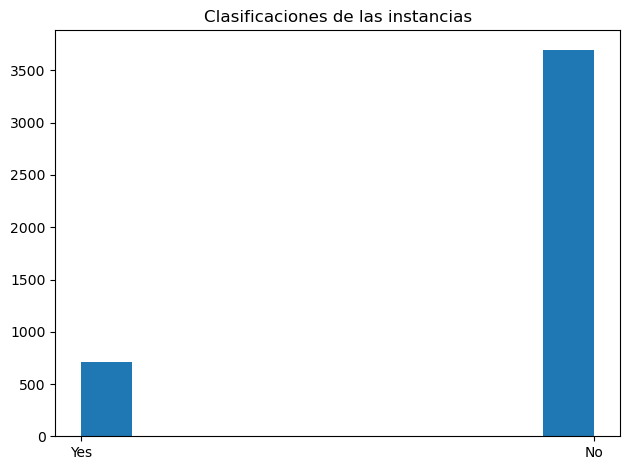

In [135]:
plt.hist(salida)
# Agregar etiquetas y título al gráfico
plt.title("Clasificaciones de las instancias")

# Ajustar los márgenes del gráfico
plt.tight_layout()
plt.show()

Como vemos este dataset se encuentra algo desbalanceado en proporción de 5 (3699) a 1 (711). Lo tendremos que tener en cuenta en los siguientes momentos:
   - Al dividir en muestras de aprendizaje y test
   - Cuando usemos Cross Validation
   - En el entrenamiento de los modelos. Casi todos los métodos en sklearn admiten un parámetro `class_weight='balanced'`

### Limpieza de datos

A continuación procederemos a limpiar nuestros datos para poder centrarnos en las características que podrían tener poder predictivo para determinar si los trabajadores abandonan la empresa o no.

Para ello, vamos a comprobar nuestros datos para asegurarnos de que no tenemos valores perdidos, o `NaN`, lo que impedirá que el modelo que escojamos se ejecute correctamente. Utlizaremos la sentencia `df.isna().any()`.

In [136]:
X_train.isna().any()

hrs                         True
absences                    True
JobInvolvement              True
PerformanceRating           True
EnvironmentSatisfaction     True
JobSatisfaction             True
WorkLifeBalance             True
Age                         True
BusinessTravel              True
Department                  True
DistanceFromHome           False
Education                   True
EducationField              True
EmployeeCount               True
Gender                      True
JobLevel                   False
JobRole                     True
MaritalStatus               True
MonthlyIncome               True
NumCompaniesWorked          True
PercentSalaryHike           True
StandardHours               True
StockOptionLevel            True
TotalWorkingYears           True
TrainingTimesLastYear      False
YearsAtCompany              True
YearsSinceLastPromotion     True
YearsWithCurrManager        True
dtype: bool

In [137]:
salida.isna().any()

False

En esta tabla, se puede observar aquellos atributos que contienen al menos un valor nulo. Si tienen al menos un valor nulo se representa con `True`, y en caso contrario con `False`. Observando los resultados obtenidos, podemos ver como todos los atributos menos 3 tienen al menos un valor nulo. Esto es importante detectarlo, pues vamos a tener que otorgarle valores “reales” en el futuro con respecto al resto de datos para que aporte una mayor información al modelo.

In [138]:
X_train.isnull().sum()

hrs                        760
absences                   743
JobInvolvement             584
PerformanceRating          666
EnvironmentSatisfaction    728
JobSatisfaction            588
WorkLifeBalance             32
Age                        735
BusinessTravel             620
Department                 660
DistanceFromHome             0
Education                  763
EducationField             639
EmployeeCount              628
Gender                     708
JobLevel                     0
JobRole                    774
MaritalStatus              706
MonthlyIncome              683
NumCompaniesWorked         596
PercentSalaryHike          753
StandardHours              692
StockOptionLevel           607
TotalWorkingYears          653
TrainingTimesLastYear        0
YearsAtCompany             609
YearsSinceLastPromotion    648
YearsWithCurrManager       668
dtype: int64

En esta segunda tabla, vemos el número de valores nulos en cada uno de los atributos. Se puede comprobar lo mencionado en el apartado anterior. Solo disponemos de `3 atributos` que no tienen valores nulos. También podemos resaltar, que por lo general los datos disponen de una gran cantidad de valores nulos, encontrándose estos en torno a un `rango de 672` de media. También podemos destacar que `WorklifeBalance` tiene un número de valores nulos muy pequeño a diferencia del resto de variables.

Vamos a dibujar los valores que son nulos

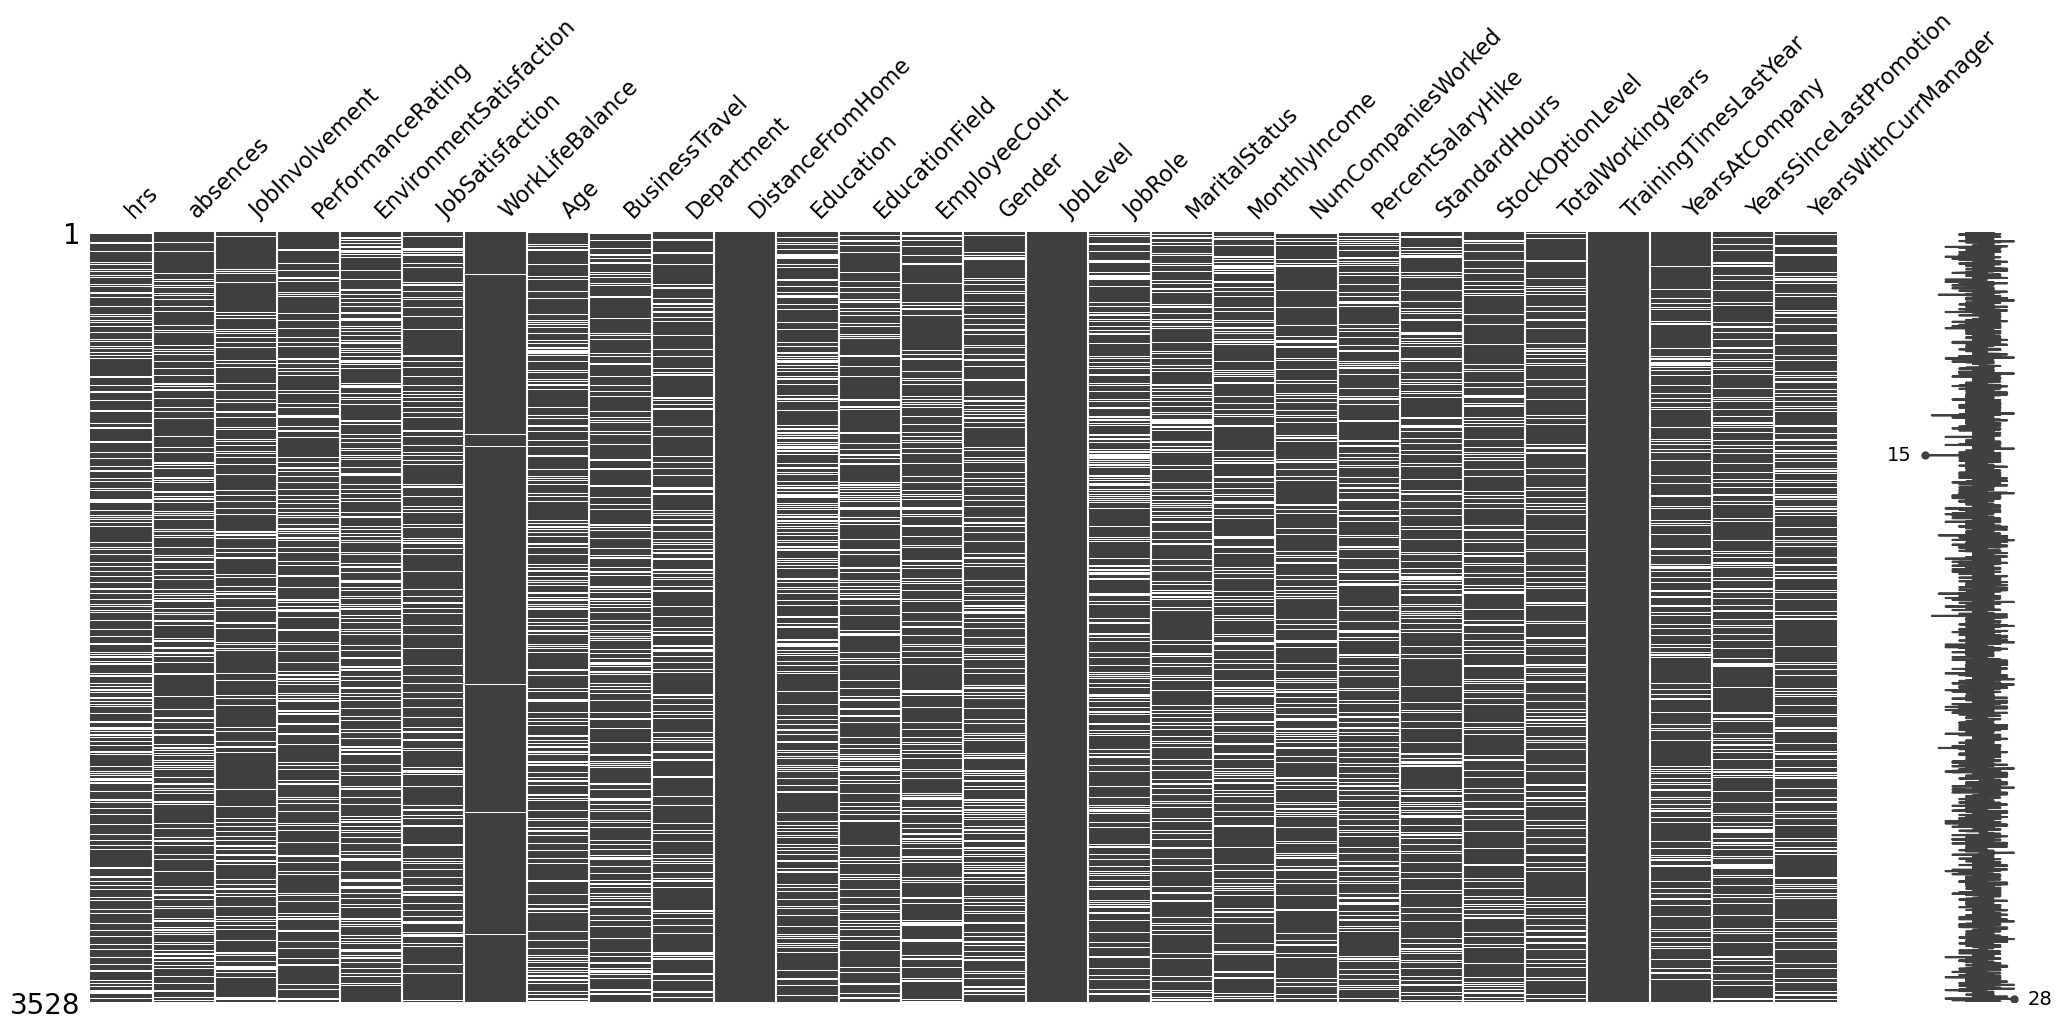

In [139]:
msno.matrix(X_train)
plt.show()

Todo lo mencionado anteriormente, se puede comprobar de formar gráfica como se puede observar arriba.

In [140]:
X_train.isnull().sum() / len(X_train) * 100

hrs                        21.541950
absences                   21.060091
JobInvolvement             16.553288
PerformanceRating          18.877551
EnvironmentSatisfaction    20.634921
JobSatisfaction            16.666667
WorkLifeBalance             0.907029
Age                        20.833333
BusinessTravel             17.573696
Department                 18.707483
DistanceFromHome            0.000000
Education                  21.626984
EducationField             18.112245
EmployeeCount              17.800454
Gender                     20.068027
JobLevel                    0.000000
JobRole                    21.938776
MaritalStatus              20.011338
MonthlyIncome              19.359410
NumCompaniesWorked         16.893424
PercentSalaryHike          21.343537
StandardHours              19.614512
StockOptionLevel           17.205215
TotalWorkingYears          18.509070
TrainingTimesLastYear       0.000000
YearsAtCompany             17.261905
YearsSinceLastPromotion    18.367347
Y

En esta tabla se muestra el porcentaje de valores nulos en sus respectivas columnas. Como se puede observar, la mayoría de los atributos (salvo aquellos que no tienen valores nulos), tienen en torno a un `20% de valores` nulos en sus muestras individuales.

Vamos a calcular las correlaciones de los valores numéricos

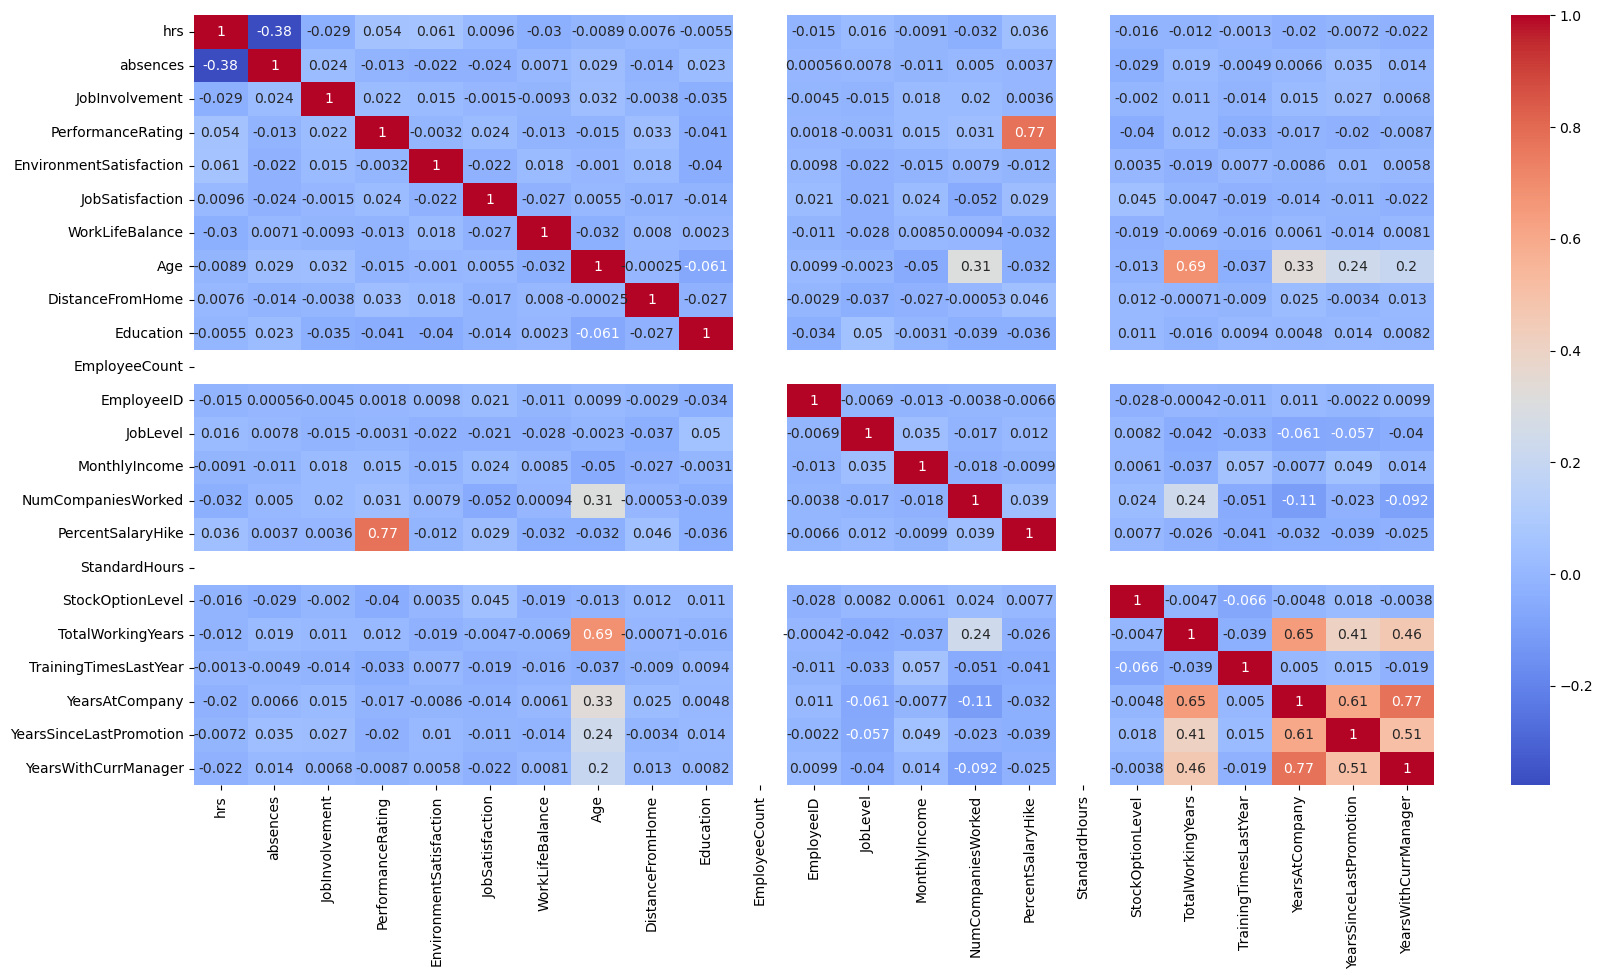

In [141]:
plt.figure(figsize=(20, 10))

# Calcula las correlaciones
correlaciones = df.corr()

# Crea un mapa de calor con las correlaciones
sns.heatmap(correlaciones, cmap='coolwarm', annot=True)

# Muestra el mapa de calor
plt.show()

Con respecto a la matriz de correlación, podemos observar datos muy interesantes que nos van a ayudar en el futuro a sacar conclusiones del modelo. Se pueden observar correlaciones significativas con respecto a las siguientes variables: `PerformanceRating – PercentSalaryHike`; `Age – TotalWorkingYears`; `YearsAtCompany – TotalWorkingYears`, y `YearsAtCompany – YearsWithCurrManager`. Como se puede observar, todas estas son relaciones que a priori son bastante lógicas con el estudio en cuestión. 

Por otro lado, se puede apreciar también bastantes atributos con correlaciones muy próximas a cero lo que implica que no aportarán mucha información al modelo. Para continuar, hemos podido observar una correlación negativa moderada entre `abs – hrs`. Esto tiene sentido también puesto que, a más horas trabajadas por el empleado, menos son las faltas que se producen en el trabajo. Esta relación, en principio, no aportará mucha información para la pregunta de la investigación, pero es conveniente tenerlo en cuenta por si resultase provechoso en el futuro. 

Por último, podemos observar que hay 2 variables cuya correlación con el resto no aparece, esto se debe a que la varianza de ambas es 0. Esto implica que no tienen correlación porque sus valores son iguales a la media. Sin embargo, no las hemos eliminado en el modelo ya que hemos comprobado que el resultado del balanced accuracy del mismo se reduce con respecto a incluirlas. Es por esta razón que las hemos mantenido pues igual hay alguna variable escondida que si que afecta a nuestro dataset en general.

## Codificamos la salida
Pasamos a codificarla con `LabelEncoder` ya que para algunas funciones como el cálculo de las curvas ROC necesitamos esta codificación. 

In [142]:
le = preprocessing.LabelEncoder()
le.fit(salida)

y_test = le.transform(y_test)
y_train = le.transform (y_train)

### Analizar tipos de variables

Vamos a visualizar los tipos de datos con los que estamos tratando para ver si son categóricos o numéricos ya que a la hora de utilizar ciertas técnicas de aprendizaje automático, estas no son capaces de soportarlos. Para ello vamos a emplear la función `.info()`.

In [143]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3528 entries, 2396 to 3086
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   hrs                      2768 non-null   float64
 1   absences                 2785 non-null   float64
 2   JobInvolvement           2944 non-null   float64
 3   PerformanceRating        2862 non-null   float64
 4   EnvironmentSatisfaction  2800 non-null   float64
 5   JobSatisfaction          2940 non-null   float64
 6   WorkLifeBalance          3496 non-null   float64
 7   Age                      2793 non-null   float64
 8   BusinessTravel           2908 non-null   object 
 9   Department               2868 non-null   object 
 10  DistanceFromHome         3528 non-null   int64  
 11  Education                2765 non-null   float64
 12  EducationField           2889 non-null   object 
 13  EmployeeCount            2900 non-null   float64
 14  Gender               

In [144]:
cat_cols = X_train.select_dtypes(include="object").columns
num_cols = X_train.select_dtypes(exclude="object").columns

In [145]:
cat_cols

Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus'],
      dtype='object')

## Decisión del  tipo de problema: ¿Regresión o Clasificación?

Como se ha podido observar anteriormente en los tipos de datos, la variable dependiente `Attrition` es una variable `discreta`, por tanto, nos encontramos ante un problema de `clasificación` ya que, si fuera de regresión, la salida sería un conjunto de datos continuos. Teniendo en cuenta todo lo anteriormente mencionado, se puede decir que nos encontramos ante un problema `supervisado` de `clasificación`, y habrá que tenerlo en cuenta para la utilización de técnicas que se nos requieren en los siguientes puntos de la práctica.

## Creación del pipeline, preprocesador

A través del pipeline, vamos a realizar un proceso de preprocesado para poder tratar los valores nulos entre otras cosas para el conjunto de datos. Divideremos el preprocesado entre uno para variables numéricas y otro para variables categóricas, ya que cada una necesita un tratamiento diferente como se explicará a continuación.


Para las variables `categóricas` vamos a crear un pipeline donde:

1. Si hubiese una muestra con valores nulos, le vamos a imputar el valor del más frecuente.
2. Codificaremos con la técnicas One_Hot_Encoder.
3. Aplicaremos sobre ellos un PCA, para extraer características más discriminantes.

In [146]:
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
    ('pca', PCA(n_components=5))
])

Ahora nos metemos con las variables `numéricas`. En este caso vamos a realizar el siguiente preproceso:
1. Si hay valores nulos, vamos a asignarles la media de sus K=5 vecinos más cercanos.
2. Realizaremos un escalado.

In [147]:
num_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', RobustScaler())
])

En el siguiente código vamos a utilizar la función `ColumnTransformer` para indicar cómo vamos a preprocesar a las variables categóricas y numéricas.

In [148]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ])

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', KNNImputer()),
                                                 ('scaler', RobustScaler())]),
                                 Index(['hrs', 'absences', 'JobInvolvement', 'PerformanceRating',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age',
       'DistanceFromHome', 'Education', 'EmployeeCount', 'JobLevel',
       'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike...
       'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False)),
                                                 ('pca', PCA(n_components=5))]),
                                 Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus'],
      dtype='object'))])

## Logistic Regression

Como ya sabemos, el clasificador base es aquel que realiza predicciones utilizando reglas simples que después  se compararan con otros clasificadores (reales). Esto quiere decir que cualquier clasificador que creemos a continuación, debería ser mejor que este.

La regresión logística es un `algoritmo supervisado` cuya función principal es la de encontrar la relación entre dos factores de datos que normalmente se representan por un número finito de resultados. En otras palabras, se emplea para modelar la probabilidad de que una observación se encuentre en una clase u otra. 

También se debe mencionar que emplea la `función sigmoide` cuyo objetivo es el de modificar y transformar los valores de entrada por una salida que se encuentre entre el rango de [0-1]. Este valor transformado, nos va a ayudar como hemos mencionado, a estimar la probabilidad de que los clasificadores que hemos dispuesto pertenezcan o no a una clase u otra.

Por último, debemos mencionar también algunas de las `principales ventajas` que caracterizan al algoritmo. Entre ellas podemos destacar su sencillez y facilidad de entrenamiento del modelo; facilidad de uso para problemas de clasificación binarios; y análisis de una variable dependiente de carácter binaria con una o más variables independientes. Por otro lado, lo más destacado en cuanto a `desventajas`, puede ser la sensibilidad que posee frente a la selección de características del modelo y la gran sensibilidad que posee frente a datos atípicos.

Para ello, vamos a crear un `Pipeline` para unir el paso del preproceso, con el paso de entrenamiento del modelo. En el entrenamiento del modelo se indica con el parámetro `class_weight='balanced'`, ya que el dataset se encuentra desbalanceado.

In [149]:
# Definimos el modelo
clf_logistic= Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(class_weight='balanced'))])

# Para que el entrenamiento del árbol también sea reproducible (en caso de que el entrenamiento del árbol sea no determinista)
np.random.seed(12)

# Entrenamiento del modelo
t_previo_log = time.time()
clf_logistic.fit(X_train, y_train)
t_final_log = time.time()

print("El tiempo de entrenamiento del modelo es de : ", t_final_log - t_previo_log ," segundos")

El tiempo de entrenamiento del modelo es de :  2.384296178817749  segundos


Vamos a ver cómo se comporta el modelo con los nuevos datos (conjunto de prueba).

In [150]:
# Predicciones del modelo
predicciones_log= clf_logistic.predict(X_test)

Aunque hay otras formas de medir el rendimiento de un modelo (precisión, recuperación, puntuación F1, curva ROC, etc.), vamos a simplificarlo y utilizar `accuracy` como primera métrica.

Accuracy se define como: predicciones correctas / número total de puntos de datos.

Sin embargo, la `balanced accuracy` se usa en problemas de clasificación binaria y multiclase para tratar conjuntos de datos desbalanceados. Se define como la media del recall obtenido en cada clase.

In [151]:
print(f"El valor de balanced accuracy: {balanced_accuracy_score(y_test, predicciones_log)}")

El valor de balanced accuracy: 0.675970688998858


Una `matriz de confusión` es una tabla que se utiliza a menudo para describir el rendimiento de un modelo de clasificación (o "clasificador") en un conjunto de datos de prueba para los que se conocen los valores verdaderos.

In [152]:
print(classification_report(y_test, predicciones_log))

              precision    recall  f1-score   support

           0       0.91      0.70      0.79       740
           1       0.30      0.65      0.41       142

    accuracy                           0.70       882
   macro avg       0.60      0.68      0.60       882
weighted avg       0.81      0.70      0.73       882



Text(0.5, 427.9555555555555, 'Predicted label')

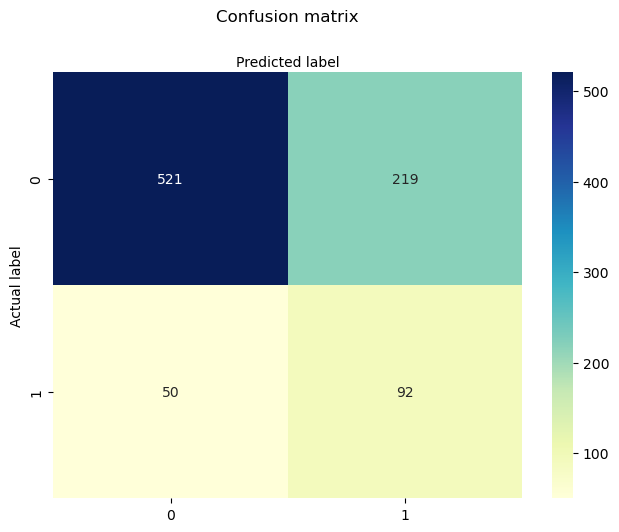

In [153]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
cnf_matrix = metrics.confusion_matrix(y_test, predicciones_log)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

De la matriz de confusión anterior podemos destacar los siguientes resultados:
-	`Precisión`: nuestro modelo ha clasificado correctamente el 91% de los de los casos con respecto a (0 – asumimos clase No). Por otro lado, en cuanto a (1 – asumimos clase Yes), solo se han clasificado correctamente el 30% de los casos. 
-	`Recall`: como ya sabemos este valor hace alusión a la sensibilidad del modelo. Mide la proporción de casos positivos que han sido identificados correctamente por el modelo. Por ello, podemos observar que los valores que hemos obtenido son 0.7 y 0.65. De todos los empleados que se han ido de la empresa, el modelo sólo predijo correctamente este resultado para el 65% de ellos.
-	`F1-score`: esta métrica mide el nivel de desempeño del modelo, siendo mejor este modelo cuanto más próximo a 1 se encuentre. Por lo tanto, con respecto a la clase negativa, tiene un desempeño del 79% siendo este bastante bueno. Sin embargo, en cuanto a la clase de instancias positivas, el nivel de desempeño es únicamente del 41% siendo este un poco escaso. 
-	`Macro average`: nos muestra el rendimiento del modelo en todas las clases. Esta medida es buena para cuando el conjunto de datos se encuentra desbalanceado. De entre todos ellos, nos vamos a centrar en el cruce entre macro average y recall. En el podemos observar un valor de 0.68; lo cual nos indica la capacidad de prediccion correcta del modelo siendo esta del 68%. En principio, este es un valor bastante reducido; sin embargo para un modelo base como este, es un buen resultado inicial.

La `curva ROC` (Receiver Operating Characteristic) es un gráfico de la tasa de verdaderos positivos frente a la tasa de falsos positivos. Muestra el equilibrio entre sensibilidad y especificidad.

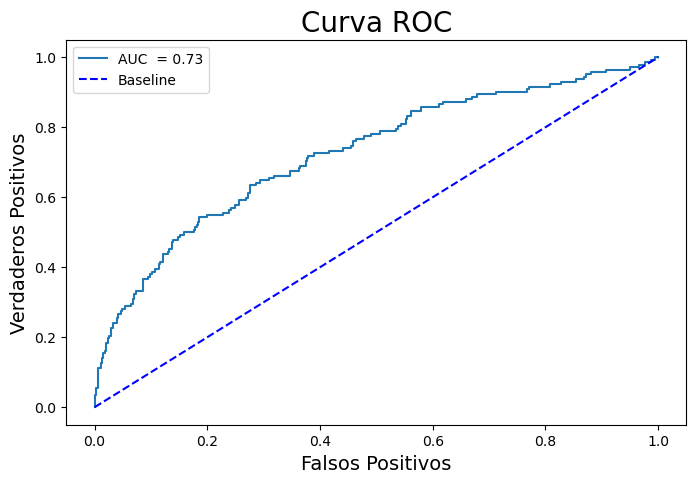

In [154]:
#Obtenemos las curva ROC y el área bajo la curva (AUC)

probs = clf_logistic.predict_proba(X_test)[:, 1]

auc = metrics.roc_auc_score(y_test, probs)
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'AUC  = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('Curva ROC', size=20)
plt.xlabel('Falsos Positivos', size=14)
plt.ylabel('Verdaderos Positivos', size=14)
plt.legend();

Como ya sabemos de clase, la `curva ROC` nos ayuda a medir u observar la capacidad que tiene el modelo de distinguir entre las dos clases del problema. Además, sabemos que su valor varía entre 0 y 1 donde 0 indicaría una mala clasificación de las instancias del conjunto de datos y 1 una clasificación perfecta de todas las instancias. El valor obtenido de AUC ha sido de 0.73 que a primera vista es bastante bueno, ya que se considera que es un valor notable a partir de 0.75.

### Ajuste de Hiperparámetros

En el caso de Logistic Regression, hay muchos hiperparámetros a tener en cuenta. Los más importantes son:

- `penalty`: El tipo de aplicación de regularización. Sus valores pueden ser:{None, 'l2' (por defecto), 'l1', 'elascticnet'}
- `C`: (por defecto 1.0) Inverso de la fuerza de regularización; Valores más pequeños especifican una regularización más fuerte.
- `solver`: Algoritmo a utilizar en el problema de optimización. Sus valores pueden ser: {‘lbfgs’ (por defecto), ‘liblinear’, ‘newton-cg’, ‘newton-cholesky’, ‘sag’, ‘saga’}. 

Conviene subrayar que el socring es balanced_accuracy ya que queremos que la medida de accuracy no sea influencia por la correcta clasificación de una clase en concreto ya que estamos tratando un problema desbalanceado.

In [155]:
log_dist = [{'classifier__penalty': ['l1', 'l2', 'elascticnet'],
               'classifier__C': [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.5, 1],
               'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}]

inner = KFold(n_splits=5, shuffle=True, random_state=12)

#budget = 40
# Cross-validation (3-fold) para la búsqueda de hiper-parámetros
grid_log = GridSearchCV (clf_logistic,
                    param_grid = log_dist,
                    scoring='balanced_accuracy',
                    cv=inner,
                    refit=True,
                    n_jobs=-1,
                    verbose=1,
                    return_train_score=True)


# Entrenar el proceso
np.random.seed(12)

t_previo_grid_log = time.time()
grid_log.fit(X_train, y_train)
t_final_grid_log = time.time()

print("El tiempo de entrenamiento del modelo es de : ", t_final_grid_log - t_previo_grid_log ," segundos")

Fitting 5 folds for each of 195 candidates, totalling 975 fits
El tiempo de entrenamiento del modelo es de :  843.9273252487183  segundos


In [156]:
resultados = pd.DataFrame(grid_log.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head()

,param_classifier__C,param_classifier__penalty,param_classifier__solver,mean_test_score,std_test_score,mean_train_score,std_train_score
79,0.05,l1,saga,0.697251,0.016309,0.702873,0.006633
77,0.05,l1,liblinear,0.692799,0.018586,0.700406,0.005996
124,0.08,l1,saga,0.692578,0.013913,0.703218,0.005641
64,0.04,l1,saga,0.692578,0.013630,0.699775,0.005634
157,0.1,l2,liblinear,0.692487,0.013340,0.702796,0.005259


In [157]:
grid_log.best_params_, grid_log.best_score_

({'classifier__C': 0.05,
  'classifier__penalty': 'l1',
  'classifier__solver': 'saga'},
 0.6972511020673376)

Vamos a ver cómo se comporta el modelo optimizado con los nuevos datos (conjunto de prueba).

In [158]:
# Predicciones del modelo
predicciones_grid_log = grid_log.predict(X_test)

0    579
1    303
dtype: int64


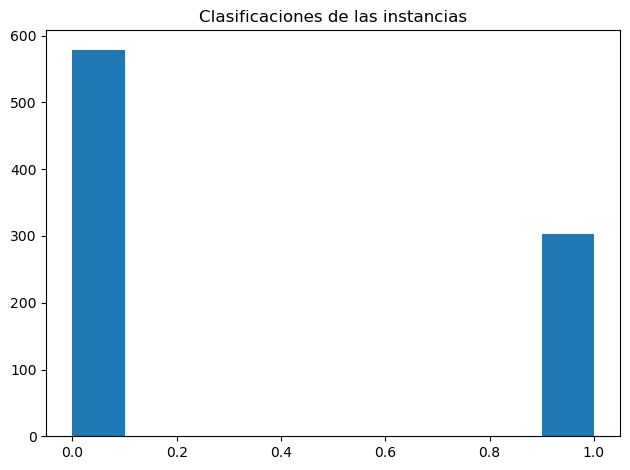

In [159]:
# Clasificaciones según el modelo de Logistic Regression

# Convertir a series de pandas para poder utilizar value_counts()
predicciones_grid_log_S = pd.Series(predicciones_grid_log)

print(predicciones_grid_log_S.value_counts())

# Histograma que muestra las clasificaciones
plt.hist(predicciones_grid_log_S)
# Agregar etiquetas y título al gráfico
plt.title("Clasificaciones de las instancias")

# Ajustar los márgenes del gráfico
plt.tight_layout()
plt.show()

Calculamos el `balanced_accuracy` del modelo de logistic regression optimizado.

In [160]:
print(f"El valor de balanced accuracy: {balanced_accuracy_score(y_test, predicciones_grid_log)}")

El valor de balanced accuracy: 0.6771792919680244


Se puede observar que el balanced accuracy que hemos obtenido es ligeramente superior (pasamos de 0.675 a 0.677)  al del modelo por defecto. Por ello es mejor alternativa el modelo ajustado.

Calculamos la `matriz de confusión` del modelo de logistic regression optimizado.

In [161]:
print(classification_report(y_test, predicciones_grid_log))

              precision    recall  f1-score   support

           0       0.91      0.71      0.80       740
           1       0.30      0.64      0.41       142

    accuracy                           0.70       882
   macro avg       0.61      0.68      0.60       882
weighted avg       0.81      0.70      0.74       882



Text(0.5, 427.9555555555555, 'Predicted label')

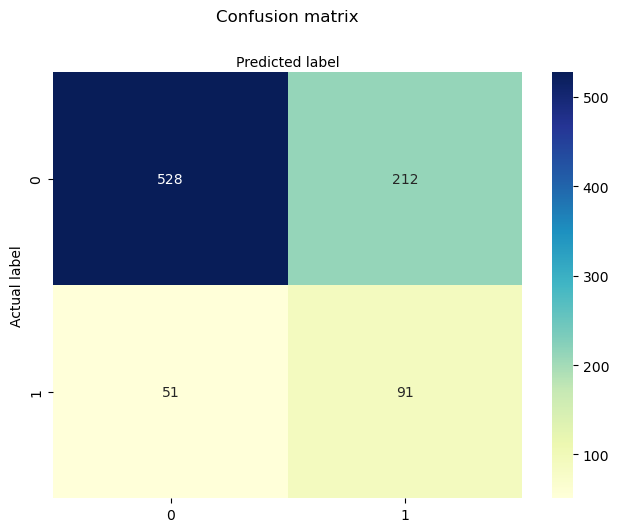

In [162]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
cnf_matrix = metrics.confusion_matrix(y_test, predicciones_grid_log)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Se puede mencionar que los valor de precisión, recall y f1-score son bastante similares con respecto al modelo sin ajustar; observando variaciones únicamente del 1%. Para los estudios de `macro avg` y `weighted` pasa exactamente lo mismo. Podemos resaltar que el valor de balanaced accuracy es exactamente el mismo (solo ha variado en dos centésimas).

Calculamos la `curva ROC` del modelo de logistic regression optimizado.

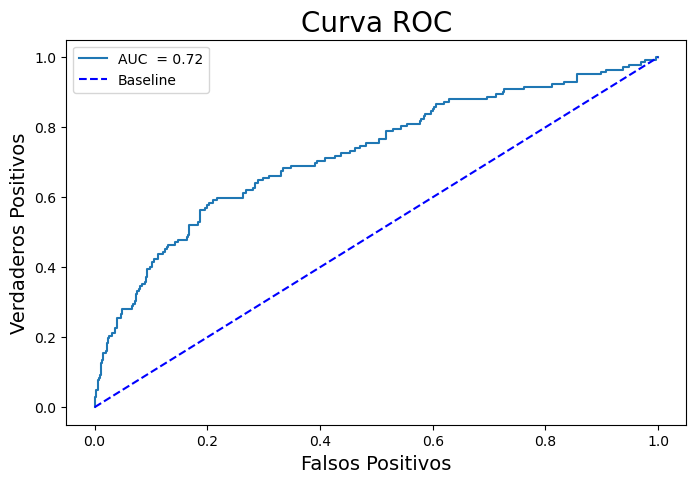

In [163]:
#Obtenemos las curva ROC y el área bajo la curva (AUC)

probs = grid_log.predict_proba(X_test)[:, 1]

auc = metrics.roc_auc_score(y_test, probs)
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'AUC  = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('Curva ROC', size=20)
plt.xlabel('Falsos Positivos', size=14)
plt.ylabel('Verdaderos Positivos', size=14)
plt.legend();

Con respecto a la curva ROC podemos observar que ha empeorado con respecto a logistic regression sin ajustar. Hemos pasado de 0.73 a 0.72.

## Boosting (SciKit-Learn)

Este algoritmo lo podemos introducir también en el apartado de aprendizaje automático de tipo `supervisado`. Suele estar representado por diferentes algoritmos dentro de scikit-learn como `AdaBoost` y `Gradient Boosting`.

Básicamente esta técnica tiene como objetivo combinar diferentes modelos débiles para conformar un modelo que sea más robusto. Por cada iteración que se produzca, se va a ir ajustando el modelo evaluando el rendimiento y asignando pesos en función de de su capacidad para predecir correctamente las instancias de entrenamiento. Además, como bien sabemos, aquellas instancias que no se encuentren bien clasificadas, se les asignará un mayor peso. De esta forma, se irá obteniendo un modelo más preciso y con mejor rendimiento. Por último, como hemos mencionado, se van a combinar todos los modelos débiles realizando una ponderación de cada uno de los modelos en función de su rendimiento.

Como es lógico, la principal `ventaja` es que mejora la precisión del modelo mediante la combinación de modelos débiles. Otro factor determinante, es que le permite tratar con valores desbalanceados ya que es capaz de manejarlo de forma efectiva. En cuanto a `desventajas`, podríamos destacar la gran sensibilidad que posee frente al ruido y datos atípicos; y su elevado coste computacional.

In [164]:
# Definimos el modelo
clf_boosting = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', HistGradientBoostingClassifier(class_weight='balanced'))])

# Para que el entrenamiento del árbol también sea reproducible (en caso de que el entrenamiento del árbol sea no determinista)
np.random.seed(12)

# Entrenamiento del modelo
t_previo_boosting = time.time()
clf_boosting.fit(X_train, y_train)
t_final_boosting = time.time()

print("El tiempo de entrenamiento del modelo es de : ", t_final_boosting - t_previo_boosting ," segundos")

El tiempo de entrenamiento del modelo es de :  5.033605575561523  segundos


Vamos a ver cómo se comporta el modelo con los nuevos datos (conjunto de prueba).

In [165]:
# Predicciones del modelo
predicciones_boosting = clf_boosting.predict(X_test)

Calculamos el `balanced_accuracy` del modelo de boosting por defecto.

In [166]:
print(f"El valor de balanced accuracy: {balanced_accuracy_score(y_test, predicciones_boosting)}")

El valor de balanced accuracy: 0.8353635325466311


Podemos observar que hemos obtenido un valor de `balanced acuracy` de `0.835`. Esto implica que el modelo de clasificación posee un buen rendimiento de la clasificación de instancias positivas y negativas. Este valor, nos sugiere que el modelo ya empieza a tener una precisión aceptable para el problema en cuestión. Además, estamos satisfechos con este resultado puesto que hemos conseguido mejorarlo con respecto a `Logistic Regression` donde obtuvimos un valor de balanced accuracy de 0.677. Hemos mejorado en un 23% el valor anterior.

Calculamos la `matriz de confusión` del modelo de boosting por defecto.

In [167]:
print(classification_report(y_test, predicciones_boosting))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       740
           1       0.77      0.71      0.74       142

    accuracy                           0.92       882
   macro avg       0.86      0.84      0.85       882
weighted avg       0.92      0.92      0.92       882



Text(0.5, 427.9555555555555, 'Predicted label')

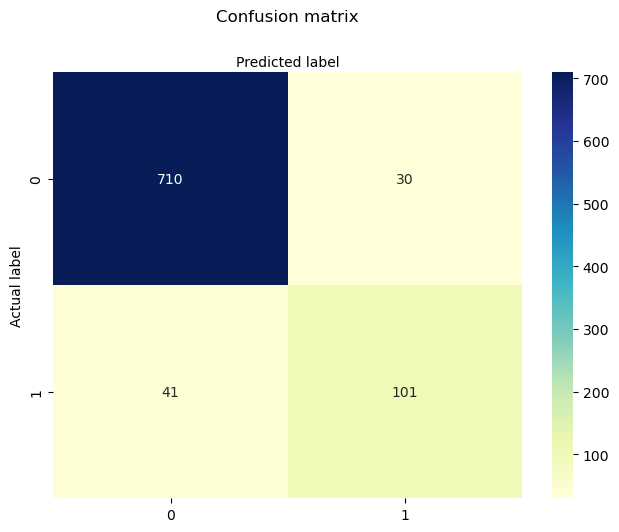

In [168]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
cnf_matrix = metrics.confusion_matrix(y_test, predicciones_boosting)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Podemos observar una mejora significativa en todos los valores de la matriz de confusión:

-	`Precisión`: nuestro modelo ha clasificado correctamente el 95% de las instancias negativas y el 77% de las instancias positivas. Esto implica que ha mejorado considerablemente pues en LogisticRegression nos encontrábamos entre valores de 91% en caso de instancias positivas y 30% en negativas. Se puede observar que el algoritmo Boosting ha producido un incremento en un 4.39% en el caso de las instancias negativas y en el caso de las instancias positivas, en un 256%. Esto nos muestra que esta técnica es bastante más efectiva a la hora de clasificar las clases.

-	`Recall`: como ya sabemos este valor hace alusión a la sensibilidad del modelo. Mide la proporción de casos positivos que han sido identificados correctamente por el modelo. Por ello, podemos observar que los valores que hemos obtenido son 0.96 y 0.71. De todos los empleados que se han ido de la empresa, el modelo predijo correctamente este resultado para el 71% de ellos.

-	`F1-score`: esta métrica mide el nivel de desempeño del modelo, siendo mejor este modelo cuanto más próximo a 1 se encuentre. Por lo tanto, con respecto a la clase negativa, tiene un desempeño del 95% siendo este bastante bueno. En cuanto a la clase de instancias positivas, el nivel de desempeño es del 74% siendo este bastante bueno en comparacion con la regresión logistica donde únicamente era del 41%. También hemos podido observar una mejora en el conjunto positivo. De nuevo, observamos que es mejor el algoritmo boosting con respecto a regresión logística. 

-	`Macro average`: nos muestra el rendimiento del modelo en todas las clases. Esta medida es buena para cuando el conjunto de datos se encuentra desbalanceado. De entre todos ellos, nos vamos a centrar en el cruce entre macro average y recall. En el podemos observar un valor de 0.84; lo cual nos indica la capacidad de predicción correcta del modelo siendo esta del 84%. Se puede observar que el valor obtenido es mejor que el que obtuvimos en logistic regression siendo este de 0.68. Esto implica que ha mejorado en un 23% con respecto al modelo anterior.


Como resultado de todo lo anterior, podemos mencionar que esta claro que el mejor algoritmo con respecto a este problema, es el de boosting, por ahora.

Calculamos la `curva ROC` del modelo de boosting por defecto.

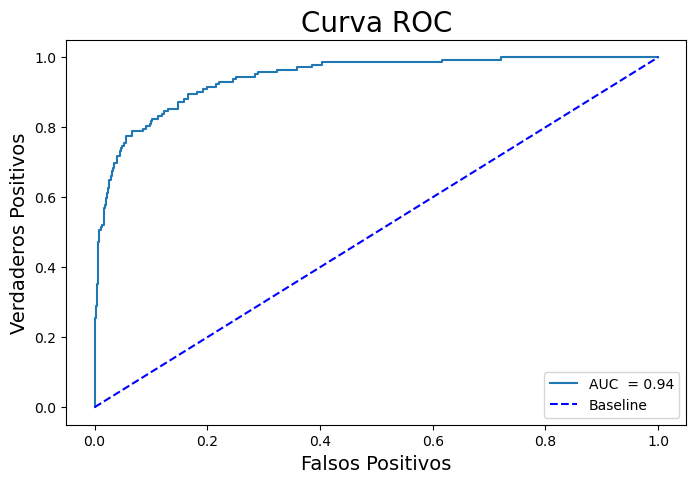

In [169]:
#Obtenemos las curva ROC y el área bajo la curva (AUC)

probs = clf_boosting.predict_proba(X_test)[:, 1]

auc = metrics.roc_auc_score(y_test, probs)
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'AUC  = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('Curva ROC', size=20)
plt.xlabel('Falsos Positivos', size=14)
plt.ylabel('Verdaderos Positivos', size=14)
plt.legend();

Con respecto a la curva `ROC` El valor obtenido ha sido de 0.94 que a primera vista es bastante bueno ya que se considera que es un valor notable a partir de 0.75. Además, el modelo ha mejorado en un 23%. Este es un incremento bastante considerable y un resultado bastante respteable también. De nuevo, mencionamos que nos mantenemos prudentes frente al buen resultado obtenido pues hay situaciones donde esto implica que el modelo esta mal realizado.

### Ajuste de Hiperparámetros

En el caso de Gradient Boosting Trees, hay muchos hiperparámetros a tener en cuenta.  Los que sirven para controlar el crecimiento de los árboles, la velocidad de aprendizaje del modelo, y los que gestionan la parada temprana para evitar overfitting, son:

- `learning_rate`: reduce la contribución de cada árbol multiplicando su influencia original por este valor.
- `max_iter`: El número máximo de iteraciones del proceso de boosting, es decir, el número máximo de árboles.
- `max_depth`: indica la profundidad máxima que puede alcanzar el árbol.
- `min_samples_split`: indica el número mínimo de observaciones que debe de tener un nodo para que pueda dividirse.
- `min_samples_leaf`: indica el número mínimo de observaciones que debe de tener cada uno de los nodos hijos para que se produzca la división.
- `validation_fraction`: proporción de datos separados del conjunto entrenamiento y empleados como conjunto de validación para determinar la parada temprana (early stopping).
- `n_iter_no_change`: número de iteraciones consecutivas en las que no se debe superar el tol para que el algoritmo se detenga (early stopping). Si su valor es None se desactiva la parada temprana.
- `tol`: porcentaje mínimo de mejora entre dos iteraciones consecutivas por debajo del cual se considera que el modelo no ha mejorado.
- `l2_regularization`: indica el valor del parámetro de regularización l2. La regularización añade la penalización a medida que aumenta la complejidad del modelo. El parámetro de regularización (λ) penaliza todos los parámetros excepto el intercepto para que el modelo generalice los datos y no se ajuste en exceso.
- `max_leaf_nodes`: indica el número máximo de hojas por cada árbol. Su valor debe ser estrictamente mayor que 1. 

Teniendo en cuenta lo anteriormente mencionado, nosotros vamos a realizar la búsqueda sobre aquellos hiperparámetros que consideramos más importantes. Estos son `max_depth`, `learning_rate`, `l2_regularization` y `max_leaf_nodes`.

In [223]:
cross_val_score(clf_boosting, X_train, y_train, cv=5, scoring="balanced_accuracy").mean()

0.7889073494738877

Tras varias pruebas, hemos determinado que estos son los mejores hiperparámetros que maximizan el valor del balanced accuracy mostrado a continuación.

In [171]:
num_transformer_dist = {'preprocessor__num__imputer__n_neighbors': list(range(2, 10)),
                        'preprocessor__num__imputer__add_indicator': [True, False]}

cat_transformer_dist = {'preprocessor__cat__imputer__strategy': ['most_frequent', 'constant'],
                        'preprocessor__cat__imputer__add_indicator': [True, False],
                        'preprocessor__cat__pca__n_components': list(range(2, 20))} # Ya que hay muchas variables categóricas con varios valores

boosting_dist = {'classifier__max_depth'         : [None, 1, 3, 5, 10, 20],
                'classifier__learning_rate'     : [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1],
                'classifier__l2_regularization' : [0, 0.1, 0.4, 0.5, 0.7, 0.8, 0.9, 1],
                'classifier__max_leaf_nodes': [3, 10, 30, 40, 50, 60]}

param_dist = {**num_transformer_dist, **cat_transformer_dist, **boosting_dist}

random_boosting = RandomizedSearchCV(clf_boosting,
                                   param_distributions=param_dist,
                                   n_iter=200)

# Entrenar el proceso
np.random.seed(12)

t_previo_random_boosting = time.time()
random_boosting.fit(X_train, y_train)
t_final_random_boosting = time.time()

print("El tiempo de entrenamiento del modelo es de : ", t_final_random_boosting - t_previo_random_boosting ," segundos")

El tiempo de entrenamiento del modelo es de :  2831.7629134655  segundos


In [172]:
random_boosting.best_score_

0.9254591846985315

In [173]:
random_boosting.best_params_

{'preprocessor__num__imputer__n_neighbors': 2,
 'preprocessor__num__imputer__add_indicator': False,
 'preprocessor__cat__pca__n_components': 18,
 'preprocessor__cat__imputer__strategy': 'most_frequent',
 'preprocessor__cat__imputer__add_indicator': False,
 'classifier__max_leaf_nodes': 30,
 'classifier__max_depth': 5,
 'classifier__learning_rate': 0.5,
 'classifier__l2_regularization': 0.7}

Vamos a ver cómo se comporta el modelo optimizado con los nuevos datos (conjunto de prueba).

In [174]:
# Predicciones del modelo
predicciones_boosting_random = random_boosting.predict(X_test)

0    760
1    122
dtype: int64


<function matplotlib.pyplot.show(close=None, block=None)>

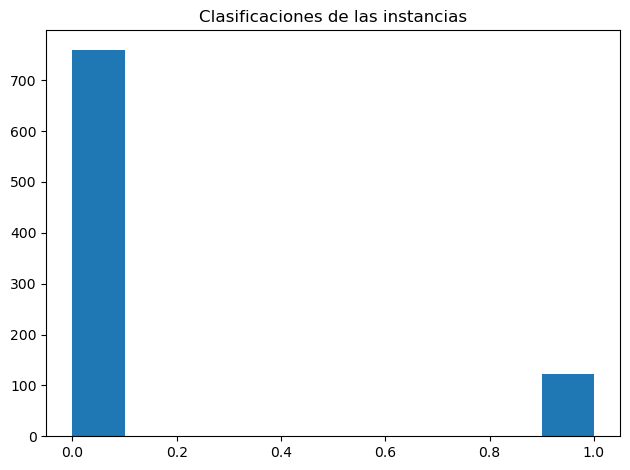

In [175]:
# Clasificaciones según el modelo de Boosting(SciKit-Learn)

# Convertir a series de pandas para poder utilizar value_counts()
predicciones_boosting_random_S = pd.Series(predicciones_boosting_random)

print(predicciones_boosting_random_S.value_counts())

# Histograma que muestra las clasificaciones
plt.hist(predicciones_boosting_random_S)
# Agregar etiquetas y título al gráfico
plt.title("Clasificaciones de las instancias")

# Ajustar los márgenes del gráfico
plt.tight_layout()
plt.show

Calculamos el `balanced_accuracy` del modelo de boosting optimizado.

In [176]:
print(f"El valor de balanced accuracy: {balanced_accuracy_score(y_test, predicciones_boosting_random)}")

El valor de balanced accuracy: 0.8708222306813855


Podemos observar que hemos obtenido un valor de `balanced acuracy` de `0.870`. Esto implica que el modelo de clasificación posee un mejor rendimiento de la clasificación de instancias positivas y negativas. Este valor, nos sugiere que el modelo tiene una precisión aceptable para el problema en cuestión. Además, estamos statisfechos con este resultado puesto que hemos conseguido mejorarlo con respecto a `boosting` normal donde obtuvimos un valor de balanced accuracy de 0.835. Hemos mejorado en un 4% el valor del modelo de boosting por defecto.

Calculamos la `matriz de confusión` del modelo de boosting optimizado.

In [177]:
print(classification_report(y_test, predicciones_boosting_random))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       740
           1       0.89      0.76      0.82       142

    accuracy                           0.95       882
   macro avg       0.92      0.87      0.89       882
weighted avg       0.94      0.95      0.94       882



Text(0.5, 427.9555555555555, 'Predicted label')

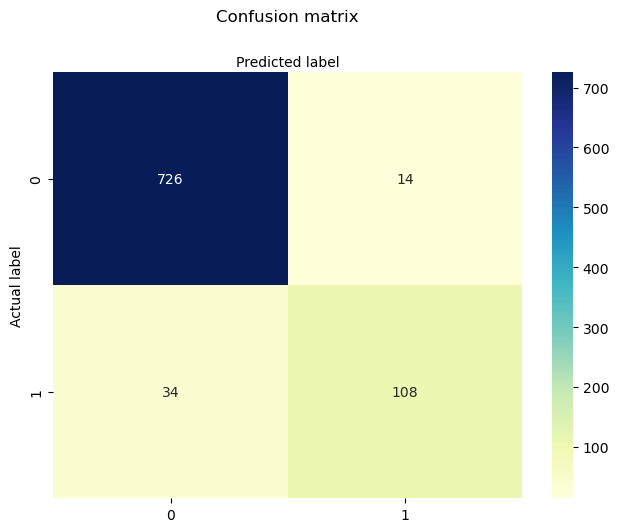

In [178]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
cnf_matrix = metrics.confusion_matrix(y_test, predicciones_boosting_random)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Podemos observar una mejora significativa en todos los valores de la matriz de confusión:

-	`Precisión`: nuestro modelo ha clasificado correctamente el 96% de las instancias negativas y el 89% de las instancias positivas. Esto implica que ha mejorado considerablemente pues en `Boosting (por defecto)` nos encontrabamos entre valores de 95% en caso de instancias positivas y 77% en negativas. Se puede observar que el algoritmo con los parámetros ajustados ha producido un incremento en un 15% en el caso de las instancias positivas; y en el caso de las instancias negativas un 1%. Esto nos muestra que esta técnica es más efectiva a la hora de clasificar las clases.

-	`Recall`: Podemos observar que los valores que hemos obtenido son 0.98 y 0.76. De todos los empleados que se han ido de la empresa, el modelo predijo correctamente este resultado para el 76% de ellos.

-	`F1-score`: esta métrica mide el nivel de desempeño del modelo, siendo mejor este modelo cuanto más próximo a 1 se encuentre. Por lo tanto, con respecto a la clase negativa, tiene un desempeño del 97% siendo este bastante bueno. En cuanto a la clase de instancias positivas, el nivel de desempeño es del 82% siendo este bastante bueno en comparación con el método boosting donde anteriormente era del 74%. También hemos podido observar una mejora en el conjunto positivo. De nuevo, observamos que es mejor el algoritmo boosting ajustado con hiperparámetros con respecto al modelo por defecto.

-	`Macro average`: nos muestra el rendimiento del modelo en todas las clases. Esta medida es buena para cuando el conjunto de datos se encuentra desbalanceado. De entre todos ellos, nos vamos a centrar en el cruce entre macro average y recall. En el podemos observar un valor de 0.87; lo cual nos indica la capacidad de predicción correcta del modelo siendo esta del 87%. Se puede observar que el valor obtenido es mejor que el que obtuvimos en logistic regression siendo este de 0.68. Esto implica que ha mejorado en un 28% con respecto al modelo anterior.

Como resultado de todo lo anterior, podemos mencionar que esta claro que el mejor algoritmo con respecto a este problema, es el de boosting con hiperparámetros ajustados; ya que obtenemos valores más elevados en todos los ámbitos de la matriz de confusión.

Calculamos la `curva ROC` del modelo de boosting optimizado.

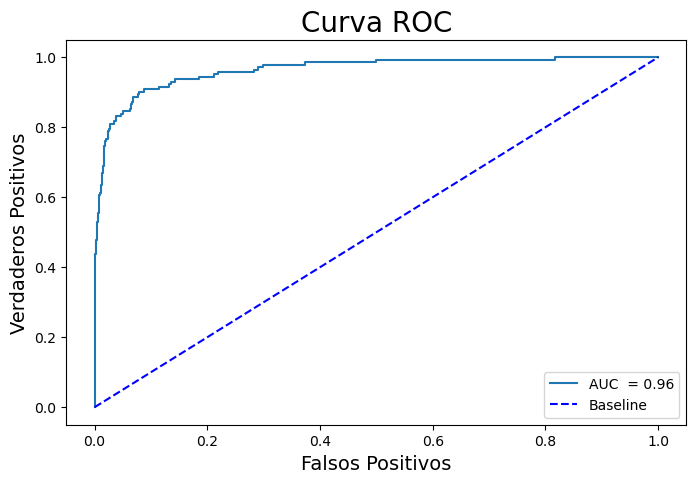

In [179]:
#Obtenemos las curva ROC y el área bajo la curva (AUC)

probs = random_boosting.predict_proba(X_test)[:, 1]

auc = metrics.roc_auc_score(y_test, probs)
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'AUC  = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('Curva ROC', size=20)
plt.xlabel('Falsos Positivos', size=14)
plt.ylabel('Verdaderos Positivos', size=14)
plt.legend();

Como se puede observar, hemos obtenido un AUC bastante bueno del 96%. Además, podemos decir que el modelo ha mejorado un 2%  con respecto al modelo anterior.

## XGBOOST

`XGBoost` también conocido como `"extreme gradient boosting"`, es un método de aprendizaje automático supervisado. Como es lógico, se emplea con árboles de decisión y su función principal es la de combinar modelos predictivos más débiles para que tengan una mayor capacidad predictiva. 

Se le conoce principalmente por mejorar el algoritmo previo de Gradient Boosting gracias a dos factores principalmente. El primero de ellos es que posee un cálculo eficiente de gradientes. El segundo de ellos es que emplea árboles de decisión regulares; reduciendo el sobreajuste y aumentando la capacidad de interpretación del modelo, su precisión y eficiencia.

Por último, en cuanto a `ventajas` y `desventajas`, podemos destacar que es un método como hemos mencionado, de una alta precisión. Además, es bastante flexible puesto que se puede emplear en una gran variedad de situaciones. En cuanto a desventajas, destaca la gran sensibilidad que posee frente a los parámetros que le podemos asignar. 

En vez de poner el parámetro de `class_weight = balanced`, como XGBoost no lo soporta, hemos utilizado el equivalente para esta técnica, `scale_pos_weight`. Este parámetro controla el balance de pesos positivos y negativos, útil para clases desequilibradas. Un valor típico a considerar: suma(instancias negativas) / suma(instancias positivas). Como al hacer esto con los counts de arriba del EDA (sum = 3699 / 711) da un valor decimal 5.2, y esto no es iterable, hemos aproximado a su valor entero que es 5.

In [180]:
# Definimos el modelo
clf_xgboost = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', XGBClassifier(scale_pos_weight = 5))])

# Para que el entrenamiento del árbol también sea reproducible (en caso de que el entrenamiento del árbol sea no determinista)
np.random.seed(12)

# Entrenamiento del modelo
t_previo_xgb = time.time()
clf_xgboost.fit(X_train, y_train)
t_final_xgb = time.time()

print("El tiempo de entrenamiento del modelo es de : ", t_final_xgb - t_previo_xgb ," segundos")

El tiempo de entrenamiento del modelo es de :  1.9659459590911865  segundos


Vamos a ver cómo se comporta el modelo con los nuevos datos (conjunto de prueba).

In [181]:
# Predicciones del modelo
predicciones_xgb= clf_xgboost.predict(X_test)

Calculamos el `balanced_accuracy` del modelo de xgboosting por defecto.

In [182]:
print(f"El valor de balanced accuracy: {balanced_accuracy_score(y_test, predicciones_xgb)}")

El valor de balanced accuracy: 0.8413018652455272


En este caso el `balanced accuracy` es de `0.841`. Podemos ver como el modelo base del XGBoost es mejor con respecto al algoritmo de boosting normal y menor que el boosting ajustado. 

Calculamos la `matriz de confusión` del modelo de xgboosting por defecto.

In [183]:
print(classification_report(y_test, predicciones_xgb))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       740
           1       0.86      0.70      0.78       142

    accuracy                           0.93       882
   macro avg       0.90      0.84      0.87       882
weighted avg       0.93      0.93      0.93       882



Text(0.5, 427.9555555555555, 'Predicted label')

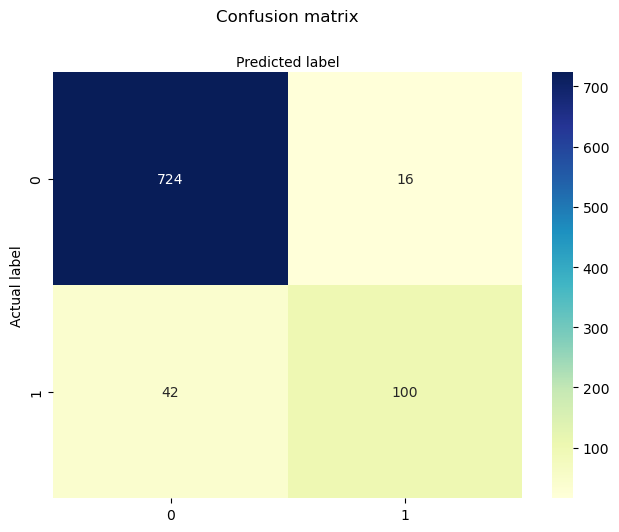

In [184]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
cnf_matrix = metrics.confusion_matrix(y_test, predicciones_xgb)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Podemos observar una mejora significativa en todos los valores de la matriz de confusión:

-	`Precisión`: nuestro modelo ha clasificado correctamente el 95% de las instancias negativas y el 86% de las instancias positivas. Esto implica que ha mejorado considerablemente pues en `Boosting (por defecto)` nos encontrabamos entre valores de 95% en caso de instancias positivas y 77% en negativas. Podemos observar que seguimos mejorando los resultados obtenidos con respecto a boosting (por defecto) y logistic regression.

-	`Recall`: Podemos observar que los valores que hemos obtenido son 0.98 y 0.70. De todos los empleados que se han ido de la empresa, el modelo predijo correctamente este resultado para el 70% de ellos. Se puede observar de nuevo que los valores obtenidos se encuentran otra vez entre medias de los obtenidos por logistic regression, boosting por defecto y boosting ajustado; encontrándose en peor lugar los dos primeros con respecto a XGBoost y peor que boosting ajustado.

-	`F1-score`: esta métrica mide el nivel de desempeño del modelo, siendo mejor este modelo cuanto más próximo a 1 se encuentre. Por lo tanto, con respecto a la clase negativa, tiene un desempeño del 96% siendo este bastante bueno. En cuanto a la clase de instancias positivas, el nivel de desempeño es del 78%. También hemos podido observar una mejora en el conjunto positivo. De nuevo, observamos que es mejor el algoritmo boosting ajustado con hiperparámetros con respecto al modelo por defecto.

-	`Macro average`: nos muestra el rendimiento del modelo en todas las clases. Esta medida es buena para cuando el conjunto de datos se encuentra desbalanceado. De entre todos ellos, nos vamos a centrar en el cruce entre macro average y recall. En el podemos observar un valor de 0.87; lo cual nos indica la capacidad de predicción correcta del modelo siendo esta del 87%. Se puede observar que el valor obtenido es mejor que el que obtuvimos en logistic regression siendo este de 0.68. Esto implica que ha mejorado en un 28% con respecto al modelo anterior.

Como resultado de todo lo anterior, podemos mencionar que esta claro que el mejor algoritmo con respecto a este problema, es el de boosting con hiperparámetros ajustados; ya que obtenemos valores más elevados en todos los ámbitos de la matriz de confusión.

Calculamos la `curva ROC` del modelo de xgboosting por defecto.

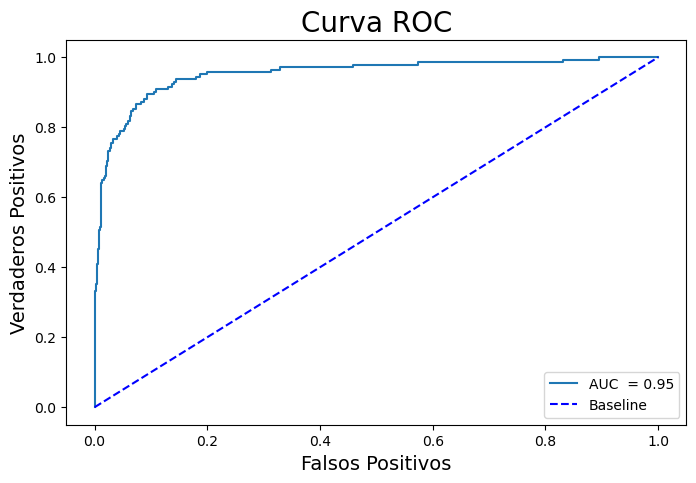

In [185]:
#Obtenemos las curva ROC y el área bajo la curva (AUC)

probs = clf_xgboost.predict_proba(X_test)[:, 1]

auc = metrics.roc_auc_score(y_test, probs)
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'AUC  = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('Curva ROC', size=20)
plt.xlabel('Falsos Positivos', size=14)
plt.ylabel('Verdaderos Positivos', size=14)
plt.legend();

Como se puede observar, hemos obtenido un AUC bastante bueno del 95%. Además, podemos decir que el modelo ha mejorado un 1% con respecto al modelo boosting por defecto.

### Ajuste de Hiperparámetros

Al igual que en el modelo anterior, Gradient Boosting, vamos a ajustar `max_depth` y `learning_rate` luego estos paráetro no necesitan de niguna introducción. No obstante, vamos a utilizar dos nuevos parámetros no explicados anteriormente. Estos son:

- `Subsample`: se refiere a la fracción de observaciones que se emplearán para construir cada árbol. En otras palabras, se encarga de controlar el muestreo de filas de entrenamiento para cada árbol.

- `N_estimators`: este hiperparámetro hace referencia al número de árboles de decisión que se van a construir en el modelo `XGBoost`. Puede ayudar a mejorar la precisión del modelo; sin embargo, hay riesgo de aumento de tiempo de entrenamiento, y de sobreajuste.

In [224]:
cross_val_score(clf_xgboost, X_train, y_train, cv=5, scoring="balanced_accuracy").mean()

0.771978085740383

In [187]:
num_transformer_dist = {'preprocessor__num__imputer__n_neighbors': list(range(2, 10)),
                        'preprocessor__num__imputer__add_indicator': [True, False]}

cat_transformer_dist = {'preprocessor__cat__imputer__strategy': ['most_frequent', 'constant'],
                        'preprocessor__cat__imputer__add_indicator': [True, False],
                        'preprocessor__cat__pca__n_components': list(range(2, 20))}

xgboosting_dist = {'classifier__max_depth'         : [None, 1, 3, 5, 10, 20],
                'classifier__learning_rate'     : [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1],
              'classifier__subsample'        : [0, 0.1, 0.4, 0.5, 0.7, 0.8, 0.9, 1],
              'classifier__n_estimators'     : list(range(50, 500, 10))}

param_dist = {**num_transformer_dist, **cat_transformer_dist, **xgboosting_dist}

random_xgboosting = RandomizedSearchCV(clf_xgboost,
                                   param_distributions=param_dist,
                                   n_iter=200)

# Entrenar el proceso
np.random.seed(12)

t_previo_random_xgboosting = time.time()
random_xgboosting.fit(X_train, y_train)
t_final_random_xgboosting = time.time()

print("El tiempo de entrenamiento del modelo es de : ", t_final_random_xgboosting - t_previo_random_xgboosting ," segundos")

El tiempo de entrenamiento del modelo es de :  2295.6146099567413  segundos


In [188]:
random_xgboosting.best_score_

0.9291423060695558

In [189]:
random_xgboosting.best_params_

{'preprocessor__num__imputer__n_neighbors': 2,
 'preprocessor__num__imputer__add_indicator': False,
 'preprocessor__cat__pca__n_components': 13,
 'preprocessor__cat__imputer__strategy': 'most_frequent',
 'preprocessor__cat__imputer__add_indicator': False,
 'classifier__subsample': 1,
 'classifier__n_estimators': 470,
 'classifier__max_depth': None,
 'classifier__learning_rate': 0.05}

Vamos a ver cómo se comporta el modelo con los nuevos datos (conjunto de prueba).

In [190]:
# Predicciones del modelo
predicciones_xgboosting_random = random_xgboosting.predict(X_test)

0    758
1    124
dtype: int64


<function matplotlib.pyplot.show(close=None, block=None)>

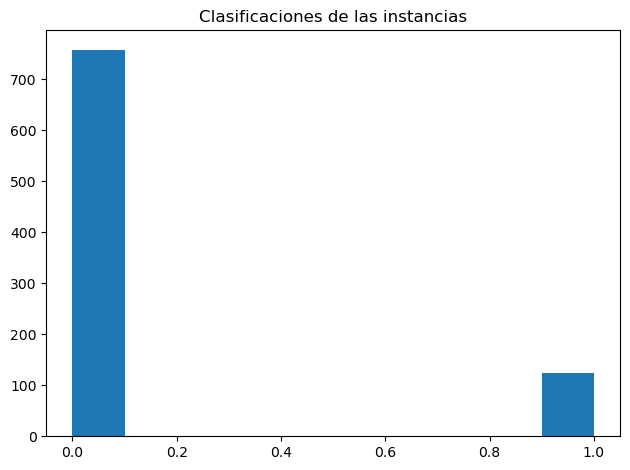

In [191]:
# Clasificaciones según el modelo de XGBOOST

# Convertir a series de pandas para poder utilizar value_counts()
predicciones_xgboosting_random_S = pd.Series(predicciones_xgboosting_random)

print(predicciones_xgboosting_random_S.value_counts())

# Histograma que muestra las clasificaciones
plt.hist(predicciones_xgboosting_random_S)
# Agregar etiquetas y título al gráfico
plt.title("Clasificaciones de las instancias")

# Ajustar los márgenes del gráfico
plt.tight_layout()
plt.show

Calculamos el `balanced_accuracy` del modelo de xgboosting optimizado.

In [192]:
print(f"El valor de balanced accuracy: {balanced_accuracy_score(y_test, predicciones_xgboosting_random)}")

El valor de balanced accuracy: 0.8778644842025123


En este caso el balanced accuracy es de 0.8778. Podemos ver como el modelo ajustado de XGBoost es el mejor con respecto al resto de modelos que hemos implementado previamente.

Calculamos la `matriz de confusión` del modelo de xgboosting optimizado.

In [193]:
print(classification_report(y_test, predicciones_xgboosting_random))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       740
           1       0.89      0.77      0.83       142

    accuracy                           0.95       882
   macro avg       0.92      0.88      0.90       882
weighted avg       0.95      0.95      0.95       882



Text(0.5, 427.9555555555555, 'Predicted label')

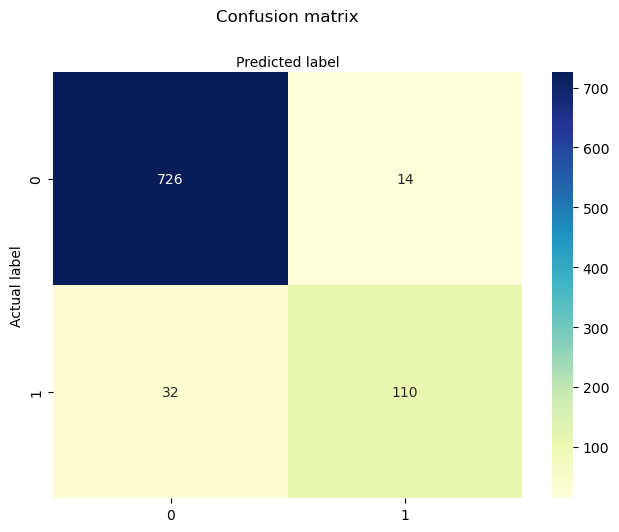

In [194]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
cnf_matrix = metrics.confusion_matrix(y_test, predicciones_xgboosting_random)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Podemos observar una mejora significativa en todos los valores de la matriz de confusión:
- `Precision`: nuestro modelo ha clasificado correctamente el 96% de las instancias negativas y el 89% de las instancias positivas. Esto implica que ha mejorado considerablemente debido a que hemos conseguido mejorar todos los valores previos de esta sección. El incremento más significativo lo hemos podido observar en la clasificación correcta de las instancias positivas con respecto al obtenido en el resto de los modelos; situándose por ejemplo en el modelo boosting en el 77%.
- `Recall`: Podemos observar que los valores que hemos obtenido son 0.98 y 0.77. De todos los empleados que se han ido de la empresa, el modelo predijo correctamente este resultado para el 77% de ellos. Se puede observar de nuevo que los valores son superiores a los de modelos anteriores y que la principal diferencia, lo podemos observar en el caso de los empleados que sí se han ido de la empresa aumentando la correcta predicción de un 70% a un 77%.

- `F1-score`: esta métrica mide el nivel de desempeño del modelo, siendo mejor este modelo cuanto más próximo a 1 se encuentre. Por lo tanto, con respecto a la clase negativa, tiene un desempeño del 97% siendo este bastante bueno. En cuanto a la clase de instancias positivas, el nivel de desempeño es del 83%. También hemos podido observar una mejora en el conjunto positivo. De nuevo, observamos que es mejor el modelo XGBoost ajustado que el resto de los modelo previamente realizados.

- `Macro average`: nos muestra el rendimiento del modelo en todas las clases. Esta medida es buena para cuando el conjunto de datos se encuentra desbalanceado. De entre todos ellos, nos vamos a centrar en el cruce entre macro average y recall. En el podemos observar un valor de 0.88; lo cual nos indica la capacidad de predicción correcta del modelo siendo esta del 88%. Se puede observar que el valor obtenido es mejor que el resto de los balanced-accuracy anteriores.

Como resultado de todo lo anterior, podemos mencionar que esta claro que el mejor algoritmo con respecto a este problema, es el de XGBoost con hiperparámetros ajustados; ya que obtenemos valores más elevados en todos los ámbitos de la matriz de confusión.

Calculamos la `curva ROC` del modelo de xgboosting optimizado.

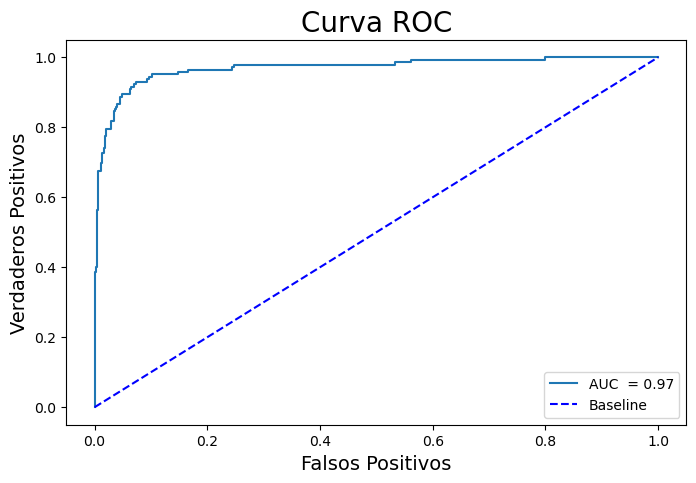

In [195]:
#Obtenemos las curva ROC y el área bajo la curva (AUC)

probs = random_xgboosting.predict_proba(X_test)[:, 1]

auc = metrics.roc_auc_score(y_test, probs)
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'AUC  = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('Curva ROC', size=20)
plt.xlabel('Falsos Positivos', size=14)
plt.ylabel('Verdaderos Positivos', size=14)
plt.legend();

Como se puede observar, hemos obtenido un AUC bastante bueno del 97%. Además, podemos decir que el modelo ha mejorado un 2% con respecto al modelo XGBoost por defecto.

## Selección de Características

En este último punto, vamos a emplear el mejor método de los obtenidos anteriormente para ver si podemos mejorar los resultados. Para la selección del mejor método, nos vamos a basar en el `balanced accuracy` que hemos obtenido de cada uno de ellos. De los anteriores métodos destaca el balanced accuracy de `XGBoost`; donde obtuvimos valores de 0.84 y 0.88 del modelo sin ajustar y ajustado, respectivamente. Es por ello, que nos basaremos en este para responder esta última pregunta.

Por ello, para resolver esta parte emplearemos métodos de selección de sklearn para ver como hemos mencionado, si mejoramos los resultados de XGBoost. Además, extraeremos conclusiones sobre los atributos más importantes de acuerdo con el método seleccionado.

In [196]:
d = [["Modelo por defecto (Logistic Regression)", balanced_accuracy_score(y_test, predicciones_log)],
     ["Boosting SciKit-Learn", balanced_accuracy_score(y_test, predicciones_boosting_random)],
     ["XGBOOST", balanced_accuracy_score(y_test, predicciones_xgboosting_random)]]

df_juntado = pd.DataFrame(d, columns = ['Modelo','Balanced Accuracy'])
print(df_juntado)

                                     Modelo  Balanced Accuracy
0  Modelo por defecto (Logistic Regression)           0.675971
1                     Boosting SciKit-Learn           0.870822
2                                   XGBOOST           0.877864


### Basados en la varianza

A continuación, emplearemos una técnica donde a través de `treshhold` eliminaremos aquellas muestras cuya varianza sea inferior al valor del treshhold que hemos especificado. En este caso será de 0.01, ya que no queremos comprometer la pérdida de información a cambio de una mejora de accuracy. Esto implica que cualquier instancia por debajo de ese valor será eliminada.

In [197]:
selector = Pipeline(steps = [('preprocessor', preprocessor), ('selector', VarianceThreshold(threshold=0.01))]) # Umbral de varianza

selector

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  Index(['hrs', 'absences', 'JobInvolvement', 'PerformanceRating',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age',
       'DistanceFromHome', 'Education', 'EmployeeCount', 'JobLevel',
       'MonthlyIncome', 'NumCom...
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('pca',
                                                                   PCA(n_components=5))]),
                                                  Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus'],
      dtype='object'))])),
                ('selector', VarianceThreshold(threshold=0.01))])

In [198]:
df_t = df['Attrition']
#df_f = df.drop('Attrition', axis=1)

sel = selector.fit(entrada)

sel_index = sel.named_steps['selector'].get_support()

if len(sel_index) < entrada.shape[1]:
    sel_index = np.append(sel_index, [False] * (entrada.shape[1] - len(sel_index)))

df_vt = entrada.iloc[:, sel_index[:entrada.shape[1]]]
print(df_vt.columns)

Index(['hrs', 'absences', 'JobInvolvement', 'PerformanceRating',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age',
       'BusinessTravel', 'Department', 'Education', 'EducationField',
       'EmployeeCount', 'Gender', 'JobRole', 'MaritalStatus', 'MonthlyIncome',
       'NumCompaniesWorked', 'PercentSalaryHike', 'StandardHours',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany', 'YearsSinceLastPromotion'],
      dtype='object')


### Mutual info
Calcula el valor de información mutua de cada una de las variables independientes con respecto a la variable dependiente y selecciona las que tienen mayor ganancia de información. En otras palabras, básicamente mide la dependencia de las características con el valor objetivo. Cuanto mayor sea la puntuación, mayor será la dependencia.

En este caso, para el mutual info, hemos decidido utilizar un treshold de 23. No hemos empleado el treshhold proporcionado en el tutorial de la práctica (de 4), debido a que consideramos que poniendo 4 se puede perder bastante información al quitar tantas variables del dataset. Además, hemos seleccionado 23 variables ya que hemos visto que los valores obtenidos en algunas variables ha sido de 0 con otros valores de threshold superiores a 23; lo que nos ha permitido eliminar las anteriores puesto que no aporta información al dataset.

In [199]:
threshold = 23  # the number of most relevant features
features = preprocessor.fit_transform(entrada)

high_score_features = []
feature_scores = mutual_info_classif(features, df_t, random_state=12)
for score, f_name in sorted(zip(feature_scores, entrada.columns), reverse=True)[:threshold]:
    print(f_name, score)
    high_score_features.append(f_name)
df_mic = entrada[high_score_features]
print(df_mic.columns)

EducationField 0.10906198576885817
YearsSinceLastPromotion 0.06462203755546292
TrainingTimesLastYear 0.06190310298288493
TotalWorkingYears 0.05907660132711312
YearsAtCompany 0.05610102737134337
StockOptionLevel 0.05530652699582794
MaritalStatus 0.029291230589512995
Age 0.02907908672532389
hrs 0.023816030465993787
NumCompaniesWorked 0.023196725423485942
StandardHours 0.021952573443962953
PercentSalaryHike 0.015341147567452529
EnvironmentSatisfaction 0.009866454830767646
DistanceFromHome 0.008316905080365977
JobRole 0.005675021009285741
JobLevel 0.005489871884832187
EmployeeCount 0.0033248959226890307
JobSatisfaction 0.003174083542549111
WorkLifeBalance 0.0031035193361401703
BusinessTravel 0.0020550821482523407
absences 0.0013707324354141903
Gender 0.00023229696309434722
MonthlyIncome 3.0211819047165633e-05
Index(['EducationField', 'YearsSinceLastPromotion', 'TrainingTimesLastYear',
       'TotalWorkingYears', 'YearsAtCompany', 'StockOptionLevel',
       'MaritalStatus', 'Age', 'hrs', 'N

En cuanto a los atributos más importantes podemos destacar aquellos que tengan un mayor nivel de ganancia de información; esto quiere decir que cuanta mayor dependencia posea con respecto a la variable dependiente, mayor será la ganancia de información del mismo. De entre las mismas podemos destacar las variables siguientes: `EducationField`, `YearsSinceLastPromotion`, `TrainingTimesLastYear`, `TotalWorkingYears`, `YearsAtCompany`. Se puede ver que estas variables tiene sentido que sean las más significativas pues pueden ser causas perfectamente comprensibles para que se vaya una persona de la empresa. Tirando de lógica común es normal que una persona se quiera ir de una empresa si no la promueven con cierta regularidad. Otra causa bastante común puede ser la cantidad de programas de entrenamiento que tiene que hacer un empleado; ya que igual considera que tiene la experiencia suficiente para no tener que realizarlo o simplemente es una pérdida de tiempo. Por último, el número de años en una empresa y el número total de años trabajados, también influyen bastante puesto que a más años trabajados en un mismo sitio más ganas de cambiar de entorno debido a diferentes factores; ya sea falta de promociones en la empresa, compañeros o carga laboral acumulada. Es por ello, que estas son las mejores variables y hemos comprobado que efectivamente tienen sentido con respecto al tema en cuestión. Por último, para relacionarlo con el EDA que hicimos, se puede ver que se ha mantenido una de las mayores correlaciones que encontramos entre `TotalWorkingYears`  y `YearsAtCompany`, donde obtuvimos una correlación de 0.65 entre las dos siendo esta elevada. Como hemos mencionado esta relación tiene sentido puesto que a más años en una compañia más años totales trabajados tendrá el empleado en total. 

Divideremos los datos siguiendo una separación de uso común con proporción 20% para `test` y 80% para `train`. Para ello, emplearemos la funcion `train_test_split`.

In [200]:
# Nueva división de los datos para las características eliminadas
X_train2,X_test2,y_train2,y_test2 = train_test_split(df_mic, salida, stratify = df_t, test_size=0.2, random_state=12, shuffle = True)

np.random.seed(12)

Pasamos a codificar la salida con `LabelEncoder` ya que para algunas funciones como el cálculo de las curvas ROC necesitamos esta codificación. 

In [201]:
le = preprocessing.LabelEncoder()
le.fit(salida)

y_test2 = le.transform(y_test2)
y_train2 = le.transform (y_train2)

Inspeccionamos las cinco primeras filas utilizando el método `.head()` para obtener una visión general de los datos y comprobar que ya no estan las características quitadas anteriormente.

In [202]:
X_train2.head()

,EducationField,YearsSinceLastPromotion,TrainingTimesLastYear,TotalWorkingYears,YearsAtCompany,StockOptionLevel,MaritalStatus,Age,hrs,NumCompaniesWorked,StandardHours,PercentSalaryHike,EnvironmentSatisfaction,DistanceFromHome,JobRole,JobLevel,EmployeeCount,JobSatisfaction,WorkLifeBalance,BusinessTravel,absences,Gender,MonthlyIncome
2396,NaN,4.0,5,NaN,10.0,0.0,Married,NaN,6.985723,3.0,NaN,NaN,2.0,24,Laboratory Technician,1,1.0,3.0,3.0,Travel_Rarely,20.0,NaN,26000.0
1453,Marketing,2.0,3,4.0,NaN,1.0,Married,32.0,6.011290,0.0,8.0,13.0,3.0,2,NaN,4,1.0,NaN,3.0,Non-Travel,9.0,Male,21090.0
1571,Life Sciences,1.0,2,16.0,13.0,1.0,Married,NaN,NaN,NaN,8.0,NaN,1.0,6,Research Scientist,2,1.0,4.0,3.0,NaN,16.0,Female,47710.0
11,NaN,10.0,2,16.0,15.0,2.0,Married,36.0,6.841840,0.0,8.0,12.0,NaN,28,Laboratory Technician,1,1.0,4.0,3.0,Travel_Rarely,8.0,Male,33770.0
1168,Technical Degree,4.0,4,6.0,6.0,0.0,NaN,NaN,6.846164,1.0,8.0,13.0,3.0,3,NaN,3,1.0,2.0,3.0,Travel_Rarely,5.0,Male,53630.0


Miramos a ver cuántas variables categóricas tenemos, para saber si es necesario o no realizar un PCA.

In [203]:
X_train2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3528 entries, 2396 to 3086
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   EducationField           2889 non-null   object 
 1   YearsSinceLastPromotion  2880 non-null   float64
 2   TrainingTimesLastYear    3528 non-null   int64  
 3   TotalWorkingYears        2875 non-null   float64
 4   YearsAtCompany           2919 non-null   float64
 5   StockOptionLevel         2921 non-null   float64
 6   MaritalStatus            2822 non-null   object 
 7   Age                      2793 non-null   float64
 8   hrs                      2768 non-null   float64
 9   NumCompaniesWorked       2932 non-null   float64
 10  StandardHours            2836 non-null   float64
 11  PercentSalaryHike        2775 non-null   float64
 12  EnvironmentSatisfaction  2800 non-null   float64
 13  DistanceFromHome         3528 non-null   int64  
 14  JobRole              

Como solo tenemos 6 variables numéricas, no hace falta realizar un análisis PCA. Este es útil cuando hay muchas variables categóricas que tienen muchos valores.

Ahora crearemos un nuevo preprocesador que no tenga en cuenta los atributos que hemos quitado anteriormente. 

Para las `variables` categóricas vamos a crear un pipeline donde:

1. Si hubiese una muestra con valores nulos, le vamos a imputar el valor del más frecuente.
2. Codificaremos con la técnicas One_Hot_Encoder.

In [204]:
cat_cols2 = X_train2.select_dtypes(include="object").columns
num_cols2 = X_train2.select_dtypes(exclude="object").columns

In [205]:
cat_transformer2 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

Ahora nos metemos con las `variables numéricas`. En este caso vamos a realizar el siguiente preproceso:
1. Si hay valores nulos, vamos a asignarles la media de sus K=5 vecinos más cercanos.
2. Realizaremos un escalado

In [206]:
num_transformer2 = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', RobustScaler())
])

En el siguiente código vamos a utilizar la función `ColumnTransformer` para indicar cómo vamos a preprocesar a las variables categóricas y numéricas.

In [207]:
preprocessor2 = ColumnTransformer(
    transformers=[
        ('num', num_transformer2, num_cols2),
        ('cat', cat_transformer2, cat_cols2)
    ])

preprocessor2

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', KNNImputer()),
                                                 ('scaler', RobustScaler())]),
                                 Index(['YearsSinceLastPromotion', 'TrainingTimesLastYear', 'TotalWorkingYears',
       'YearsAtCompany', 'StockOptionLevel', 'Age', 'hrs',
       'NumCompaniesWorked', 'StandardHours', 'PercentSalaryHike',
       'EnvironmentSatisfaction', 'DistanceFromHome', 'JobLevel',
       'EmployeeCount', 'JobSatisfaction', 'WorkLifeBalance', 'absences',
       'MonthlyIncome'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['EducationField', 'MaritalStatus', 'JobRole', 'BusinessTravel',
       'Gender'],
      dtype='object'))])

Ahora vamos a definir el nuevo modelo de XGBOOST, sin los atributos que hemos eliminado, y procederemos a entrenarlo y evaluarlo para posteriormente compararlo con el XGBOOST anterior y ver si mejora o empeora su desempeño.

In [208]:
# Definimos el modelo
clf_xgboost_mutual = Pipeline(steps=[('preprocessor', preprocessor2),
                      ('classifier', XGBClassifier(scale_pos_weight = 5))])

# Para que el entrenamiento del árbol también sea reproducible (en caso de que el entrenamiento del árbol sea no determinista)
np.random.seed(12)

In [210]:
num_transformer_dist2 = {'preprocessor__num__imputer__n_neighbors': list(range(2, 10)),
                        'preprocessor__num__imputer__add_indicator': [True, False]}

cat_transformer_dist2 = {'preprocessor__cat__imputer__strategy': ['most_frequent', 'constant'],
                        'preprocessor__cat__imputer__add_indicator': [True, False]}

xgboosting_dist2 = {'classifier__max_depth'         : [None, 1, 3, 5, 10, 20],
                'classifier__learning_rate'     : [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1],
              'classifier__subsample'        : [0, 0.1, 0.4, 0.5, 0.7, 0.8, 0.9, 1],
              'classifier__n_estimators'     : list(range(50, 500, 10))}

param_dist2 = {**num_transformer_dist2, **cat_transformer_dist2, **xgboosting_dist2}

random_xgboosting_mutual= RandomizedSearchCV(clf_xgboost_mutual,
                                   param_distributions=param_dist2,
                                   n_iter=200)

# Entrenar el proceso
np.random.seed(12)

t_previo_random_xgboosting2 = time.time()
random_xgboosting_mutual.fit(X_train2, y_train2)
t_final_random_xgboosting2 = time.time()

print("El tiempo de entrenamiento del modelo es de : ", t_final_random_xgboosting2 - t_previo_random_xgboosting2 ," segundos")

El tiempo de entrenamiento del modelo es de :  2190.9678580760956  segundos


In [211]:
random_xgboosting_mutual.best_score_

0.926021336869387

In [212]:
random_xgboosting_mutual.best_params_

{'preprocessor__num__imputer__n_neighbors': 9,
 'preprocessor__num__imputer__add_indicator': False,
 'preprocessor__cat__imputer__strategy': 'constant',
 'preprocessor__cat__imputer__add_indicator': False,
 'classifier__subsample': 0.9,
 'classifier__n_estimators': 410,
 'classifier__max_depth': 10,
 'classifier__learning_rate': 0.05}

Vamos a ver cómo se comporta el modelo con los nuevos datos (conjunto de prueba).

In [213]:
# Predicciones del modelo
predicciones_xgboosting_random_mutual = random_xgboosting_mutual.predict(X_test2)

A continuación, imprimiremos aquellas instancias clasificadas en cada una de las clases siendo estas positivas o negativas. 

0    779
1    103
dtype: int64


<function matplotlib.pyplot.show(close=None, block=None)>

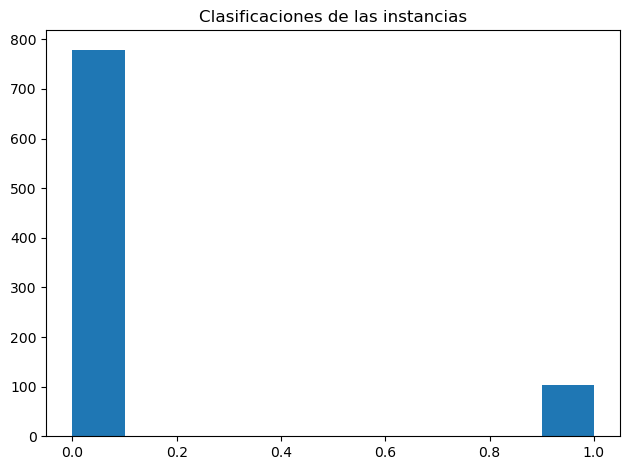

In [214]:
# Clasificaciones según el modelo de XGBOOST (Seleccion de caracteristicas)

# Convertir a series de pandas para poder utilizar value_counts()
predicciones_xgboosting_random_mutual_S = pd.Series(predicciones_xgboosting_random_mutual)

print(predicciones_xgboosting_random_mutual_S.value_counts())

# Histograma que muestra las clasificaciones
plt.hist(predicciones_xgboosting_random_mutual_S)
# Agregar etiquetas y título al gráfico
plt.title("Clasificaciones de las instancias")

# Ajustar los márgenes del gráfico
plt.tight_layout()
plt.show

Calculamos el `balanced_accuracy` del modelo de xgboosting.

In [215]:
print(f"El valor de balanced accuracy: {balanced_accuracy_score(y_test2, predicciones_xgboosting_random_mutual)}")

El valor de balanced accuracy: 0.8249048344118767


Se puede observar que el valor del balanced accuracy es inferior al obtenido en el modelo XGBoost con hiperparámetros ajustados. Debido a que estamos basando la calidad del modelo en función del balanced accuracy, podemos mencionar que el mejor modelo es el de XGBoost con ajuste de hiperparámetros donde obtuvimos un valor de 0.88, notablemente superior al obtenido en este modelo de selección de características de 0.82.  

Calculamos la `matriz de confusión` del modelo de xgboosting.

In [216]:
print(classification_report(y_test2, predicciones_xgboosting_random_mutual))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       740
           1       0.91      0.66      0.77       142

    accuracy                           0.94       882
   macro avg       0.93      0.82      0.86       882
weighted avg       0.93      0.94      0.93       882



Text(0.5, 427.9555555555555, 'Predicted label')

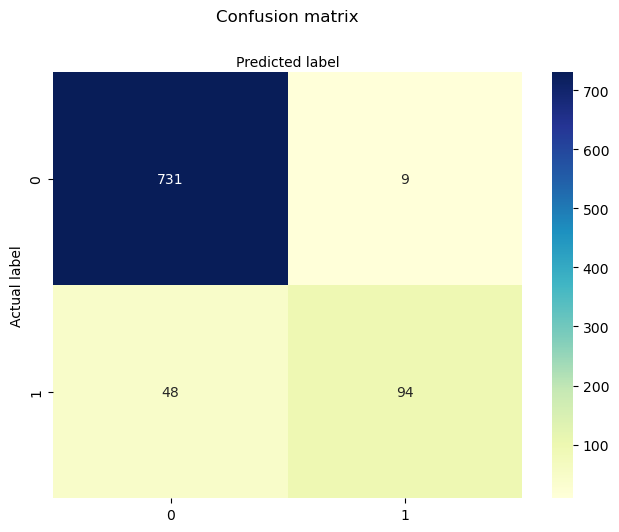

In [217]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
cnf_matrix = metrics.confusion_matrix(y_test2, predicciones_xgboosting_random_mutual)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

- `Precisión`: Se puede observar que el modelo nuevo ha obtenido unos resultados también bastante decentes en cuanto a clasificación de las instancias positivas y negativas; siendo estas entre el 94% y el 91%.
- `Recall`:   podemos observar que los valores que hemos obtenido son 0.99 y 0.66. De todos los empleados que se han ido de la empresa, el modelo predijo correctamente este resultado para el 66% de ellos. Se puede observar de nuevo que los valores obtenidos son inferirores que los del XGBoost ajustado donde obtuvimos un valor de 0.77.
- `F1-score`:  en cuanto al nivel de desempeño, podemos destacar un desempeño del 96% para el caso de la clase negativa; y un 77% en el caso de la positiva. Se puede observar una gran diferencia entre ambos; sin embargo, seguimos obteniendo resultados bastante buenos dentro de lo que cabe.

En cuanto a las siguientes variables, nos vamos a fijar en la que hemos obtenido como `balanced-accuracy` (se corresponde con el cruce entre macro avg y recall). Hemos obtenido un rendimiento del modelo en todas las clases de 82%. Esto implica que la precisión del modelo ha bajado con respecto al modelo `XGBoost ajustado` por hiperparámetros; donde obtuvimos un balanced accuracy del 88%.

Calculamos la `curva ROC` del modelo de xgboosting.

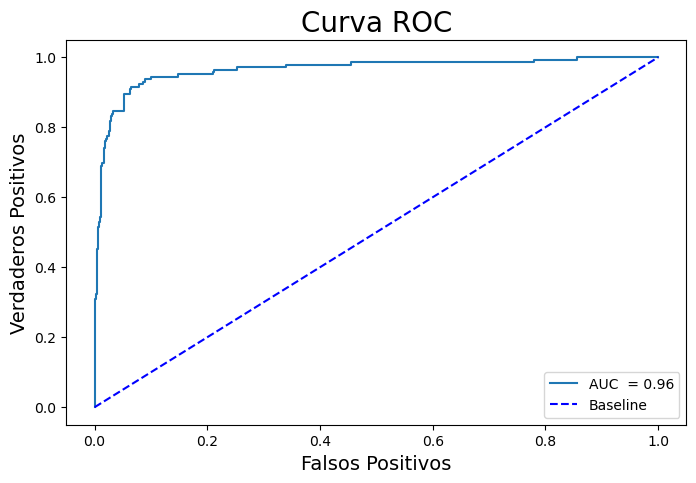

In [218]:
#Obtenemos las curva ROC y el área bajo la curva (AUC)

probs = random_xgboosting_mutual.predict_proba(X_test2)[:, 1]

auc = metrics.roc_auc_score(y_test2, probs)
fpr, tpr, thresholds = metrics.roc_curve(y_test2, probs)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'AUC  = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('Curva ROC', size=20)
plt.xlabel('Falsos Positivos', size=14)
plt.ylabel('Verdaderos Positivos', size=14)
plt.legend();

Con respecto a la curva `ROC` el valor obtenido ha sido de 0.96. Este resultado a primera vista es bastante bueno ya que se considera que es un valor notablemente bueno a partir de 0.75. Sin embargo, hay que mencionar, que el valor del AUC ha empeorado ligeramente con respecto al modelo de XGBoost ajustado; donde obtuvimos un AUC de 0.97.

## Selección del mejor modelo

Para poder determinar cuál de los métodos es el mejor, vamos a realizar una comparativa con el mejor método sin selección de características y el modelo una vez se ha realizado la selección de características. Como se puede observar, para nuestro conjunto de datos, el mejor modelo es el de `XGBOOST` por casi un 5% de diferencia. 

In [219]:
d_final = [["XGBOOST", balanced_accuracy_score(y_test, predicciones_xgboosting_random)],
           ["XGBOOST(Selección de Características)", balanced_accuracy_score(y_test2, predicciones_xgboosting_random_mutual)]]

df_final = pd.DataFrame(d_final, columns = ['Modelo','Balanced Accuracy'])
print(df_final)

                                  Modelo  Balanced Accuracy
0                                XGBOOST           0.877864
1  XGBOOST(Selección de Características)           0.824905


Una vez hemos seleccionado el mejor método de los evaluados en los puntos anteriores, entrenamos el modelo final y lo guardaremos en un fichero (llamado «`modelo_final.pkl`»).

In [220]:
MODELO_FINAL = random_xgboosting.best_estimator_
MODELO_FINAL_ENTRENADO = MODELO_FINAL.fit(X_train, y_train)

In [221]:
# Guardamos el modelo un fichero pkl
pkl_filename = "modelo_final.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(MODELO_FINAL_ENTRENADO, file)

A  modo de conclusión, queremos mencionar un planteamiento general del dataset en total. Se puede observar que en todos los modelos se produce una mejor clasificación de las clases negativas(empleados) que se quedan en comparación a la clase positiva(empleados) que se van. Esto se puede deber a que por lo general es mayor la gente que se queda en la empresa  con respecto a la que se va. Además, podemos ver esta relación en el EDA que hemos reaizado al principio de la práctica donde hemos podido ver que el conjunto de datos esta desbalanceado en torno a la clase negativa (una relacion de 5 a 1). Además, esto explica que se realicen una mejor clasificación de estas instancias en todos los modelos. 

## Bibliografía

-  Brownlee, J. (2021). Gradient Boosting with Scikit-Learn, XGBoost, LightGBM, and CatBoost. MachineLearningMastery.com. https://machinelearningmastery.com/gradient-boosting-with-scikit-learn-xgboost-lightgbm-and-catboost/ 
- Galarnyk, M. (2022, 27 abril). Logistic Regression using Python (scikit-learn) - Towards Data Science. Medium. https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a 
- Navlani, A. (2019). Understanding Logistic Regression in Python Tutorial. https://www.datacamp.com/tutorial/understanding-logistic-regression-python 
- Nelson, D. (2023). Gradient Boosting Classifiers in Python with Scikit-Learn. Stack Abuse. https://stackabuse.com/gradient-boosting-classifiers-in-python-with-scikit-learn/ 
- ¿Qué es la regresión logística? - Explicación del modelo de regresión logística - AWS. (s. f.). Amazon Web Services, Inc. https://aws.amazon.com/es/what-is/logistic-regression/ 
- sklearn.feature_selection.mutual_info_classif. (s. f.). scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html 
- sklearn.model_selection.train_test_split. (s. f.). scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html 
- sklearn.linear_model.LogisticRegression. (s. f.). scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html 
- sklearn.ensemble.GradientBoostingClassifier. (s. f.). scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
- sklearn.ensemble.HistGradientBoostingClassifier. (s. f.). scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html 
- XGBoost Parameters — xgboost 2.0.0-dev documentation. (s. f.). https://xgboost.readthedocs.io/en/latest/parameter.html 
- Zach. (2022). How to Interpret the Classification Report in sklearn (With Example). Statology. https://www.statology.org/sklearn-classification-report/ 